In [1]:
!pip install networkX
!pip install partition-networkx
# !pip install community
!pip install python-louvain

In [2]:
import cupy as cp
import cudf, cuml
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx

In [3]:
train_data = cudf.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
print(train_data.columns)
labels = train_data['isFraud']
cudf_df = train_data[[col for col in train_data.columns if col.startswith("V")]]
import gc
del train_data
gc.collect()
cudf_df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=339)

In [4]:
#do the Nans in any columns correlate directly with the transaction being a Fraud? 
#Answer: No!
# labels_gpu = labels.to_cupy()
# correlations = cp.full(len(cudf_df.columns), cp.nan)
# for idx, col in enumerate(cudf_df.columns):
#     mask = cudf_df[col].isna()
#     nan_vector = cp.full(len(cudf_df), 0.0)
#     nan_vector[mask.to_cupy()] = 1 
#     correlations[idx] = cp.corrcoef(nan_vector, labels_gpu)[0, 1]
# print(cp.min(correlations), cp.max(correlations))

In [5]:
#groupby num_nan
columns = cudf_df.columns
num_nans = cudf.DataFrame({
    "col": cudf_df.columns,
    "num_nan": cudf_df.isna().sum().values
})
num_nans['percent_nan'] = 100*num_nans['num_nan']/len(cudf_df)
print(num_nans.sort_values('percent_nan'))

      col  num_nan  percent_nan
278  V279       12     0.002032
279  V280       12     0.002032
283  V284       12     0.002032
284  V285       12     0.002032
285  V286       12     0.002032
..    ...      ...          ...
156  V157   508595    86.123717
157  V158   508595    86.123717
160  V161   508595    86.123717
161  V162   508595    86.123717
162  V163   508595    86.123717

[339 rows x 3 columns]


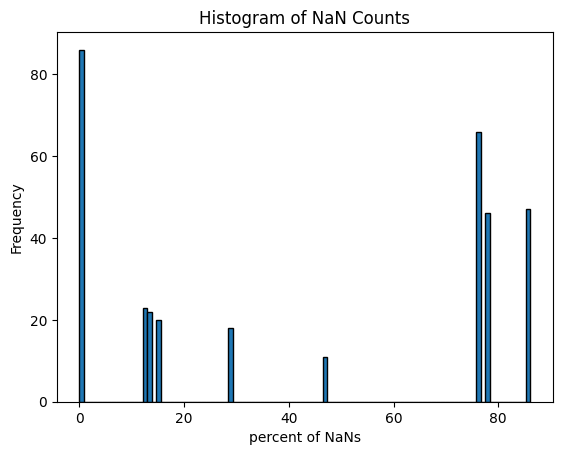

[2.03203847e-03 5.31716734e-02 2.14888069e-01 1.28819386e+01
 1.30551698e+01 1.50987232e+01 2.86126257e+01 4.72934941e+01
 7.60531039e+01 7.63235344e+01 7.63553697e+01 7.79134352e+01
 8.60549666e+01 8.61227013e+01 8.61237173e+01]


In [6]:
num_nans_array = num_nans['percent_nan'].to_cupy()
plt.hist(num_nans_array.get(), bins=100, edgecolor="k")
plt.title("Histogram of NaN Counts")
plt.xlabel("percent of NaNs")
plt.ylabel("Frequency")
plt.show()
print(cp.unique(num_nans_array))

In [7]:
#group cols using their num_nan values
import pandas as pd
nan_groups = num_nans.to_pandas().groupby(['num_nan']).agg(
    cols_in_group=('col', lambda x: list(x)),
    num_cols_in_group=('col', lambda x: len(list(x)))).reset_index()
print(nan_groups)

    num_nan                                      cols_in_group  \
0        12  [V279, V280, V284, V285, V286, V287, V290, V29...   
1       314  [V95, V96, V97, V98, V99, V100, V101, V102, V1...   
2      1269  [V281, V282, V283, V288, V289, V296, V300, V30...   
3     76073  [V12, V13, V14, V15, V16, V17, V18, V19, V20, ...   
4     77096  [V53, V54, V55, V56, V57, V58, V59, V60, V61, ...   
5     89164  [V75, V76, V77, V78, V79, V80, V81, V82, V83, ...   
6    168969  [V35, V36, V37, V38, V39, V40, V41, V42, V43, ...   
7    279287     [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11]   
8    449124  [V220, V221, V222, V227, V234, V238, V239, V24...   
9    450721  [V169, V170, V171, V174, V175, V180, V184, V18...   
10   450909  [V167, V168, V172, V173, V176, V177, V178, V17...   
11   460110  [V217, V218, V219, V223, V224, V225, V226, V22...   
12   508189  [V322, V323, V324, V325, V326, V327, V328, V32...   
13   508589  [V143, V144, V145, V150, V151, V152, V159, V16...   
14   50859

In [8]:
def plot_graph(G, partitions):
    # Add partitions as node attributes
    nx.set_node_attributes(G, partitions, "partition")
    # Generate positions for the graph
    pos = nx.spring_layout(G)  # Spring layout for a visually appealing structure
    # Extract partition colors
    partition_colors = [partitions[node] for node in G.nodes()]
    # Plot the graph
    plt.figure(figsize=(4, 4))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=partition_colors,
        cmap=plt.cm.tab20,
        node_size=500,
        font_size=10,
        edge_color='gray'
    )
    plt.title("Graph Visualization with Spring Layout and Partitions")
    plt.show()
    

0 32 cols
['V279', 'V280', 'V284', 'V285', 'V286', 'V287', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298', 'V299', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']


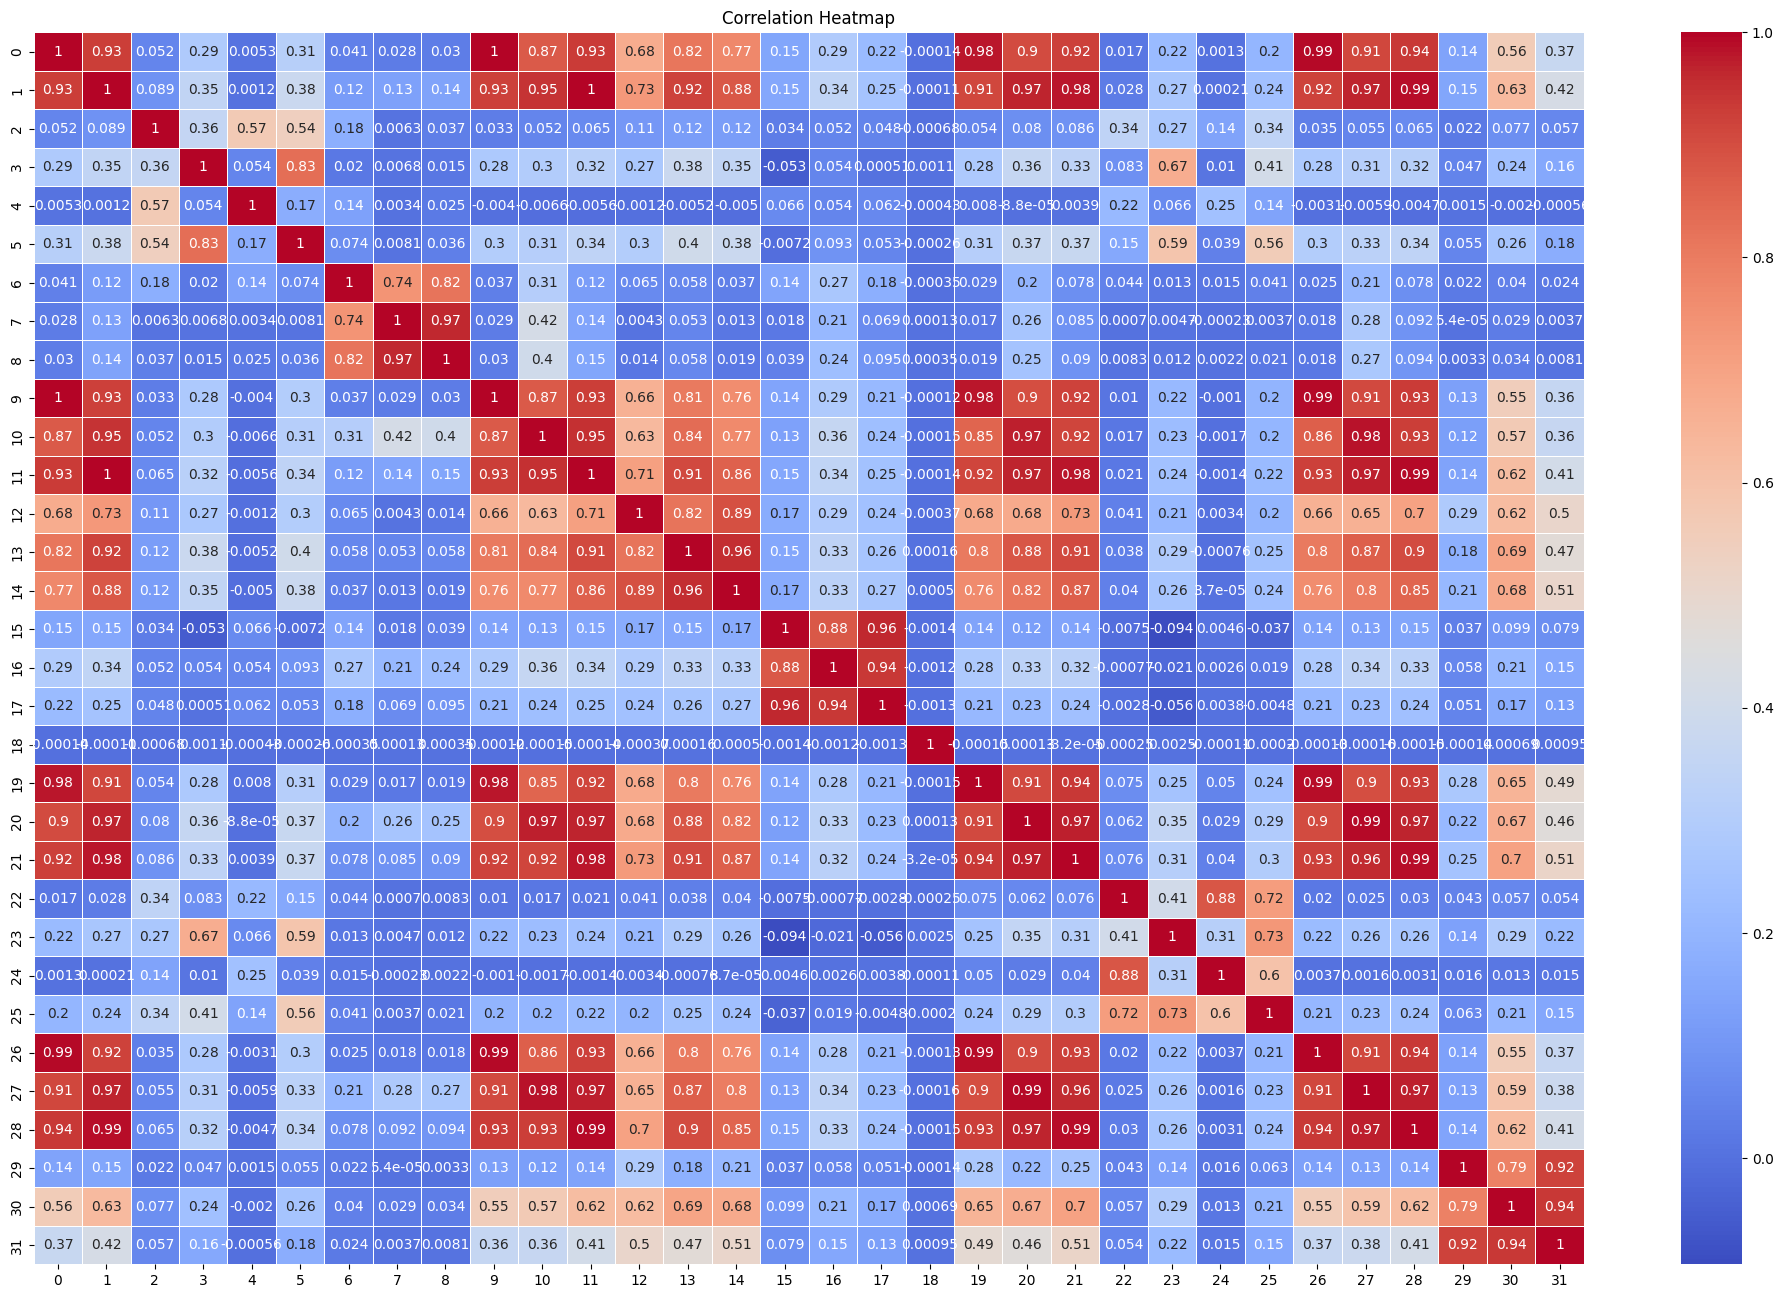

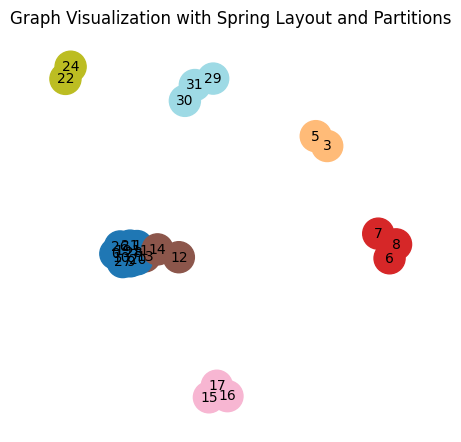

____________________________________________________________________________________________________
1 43 cols
['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137']


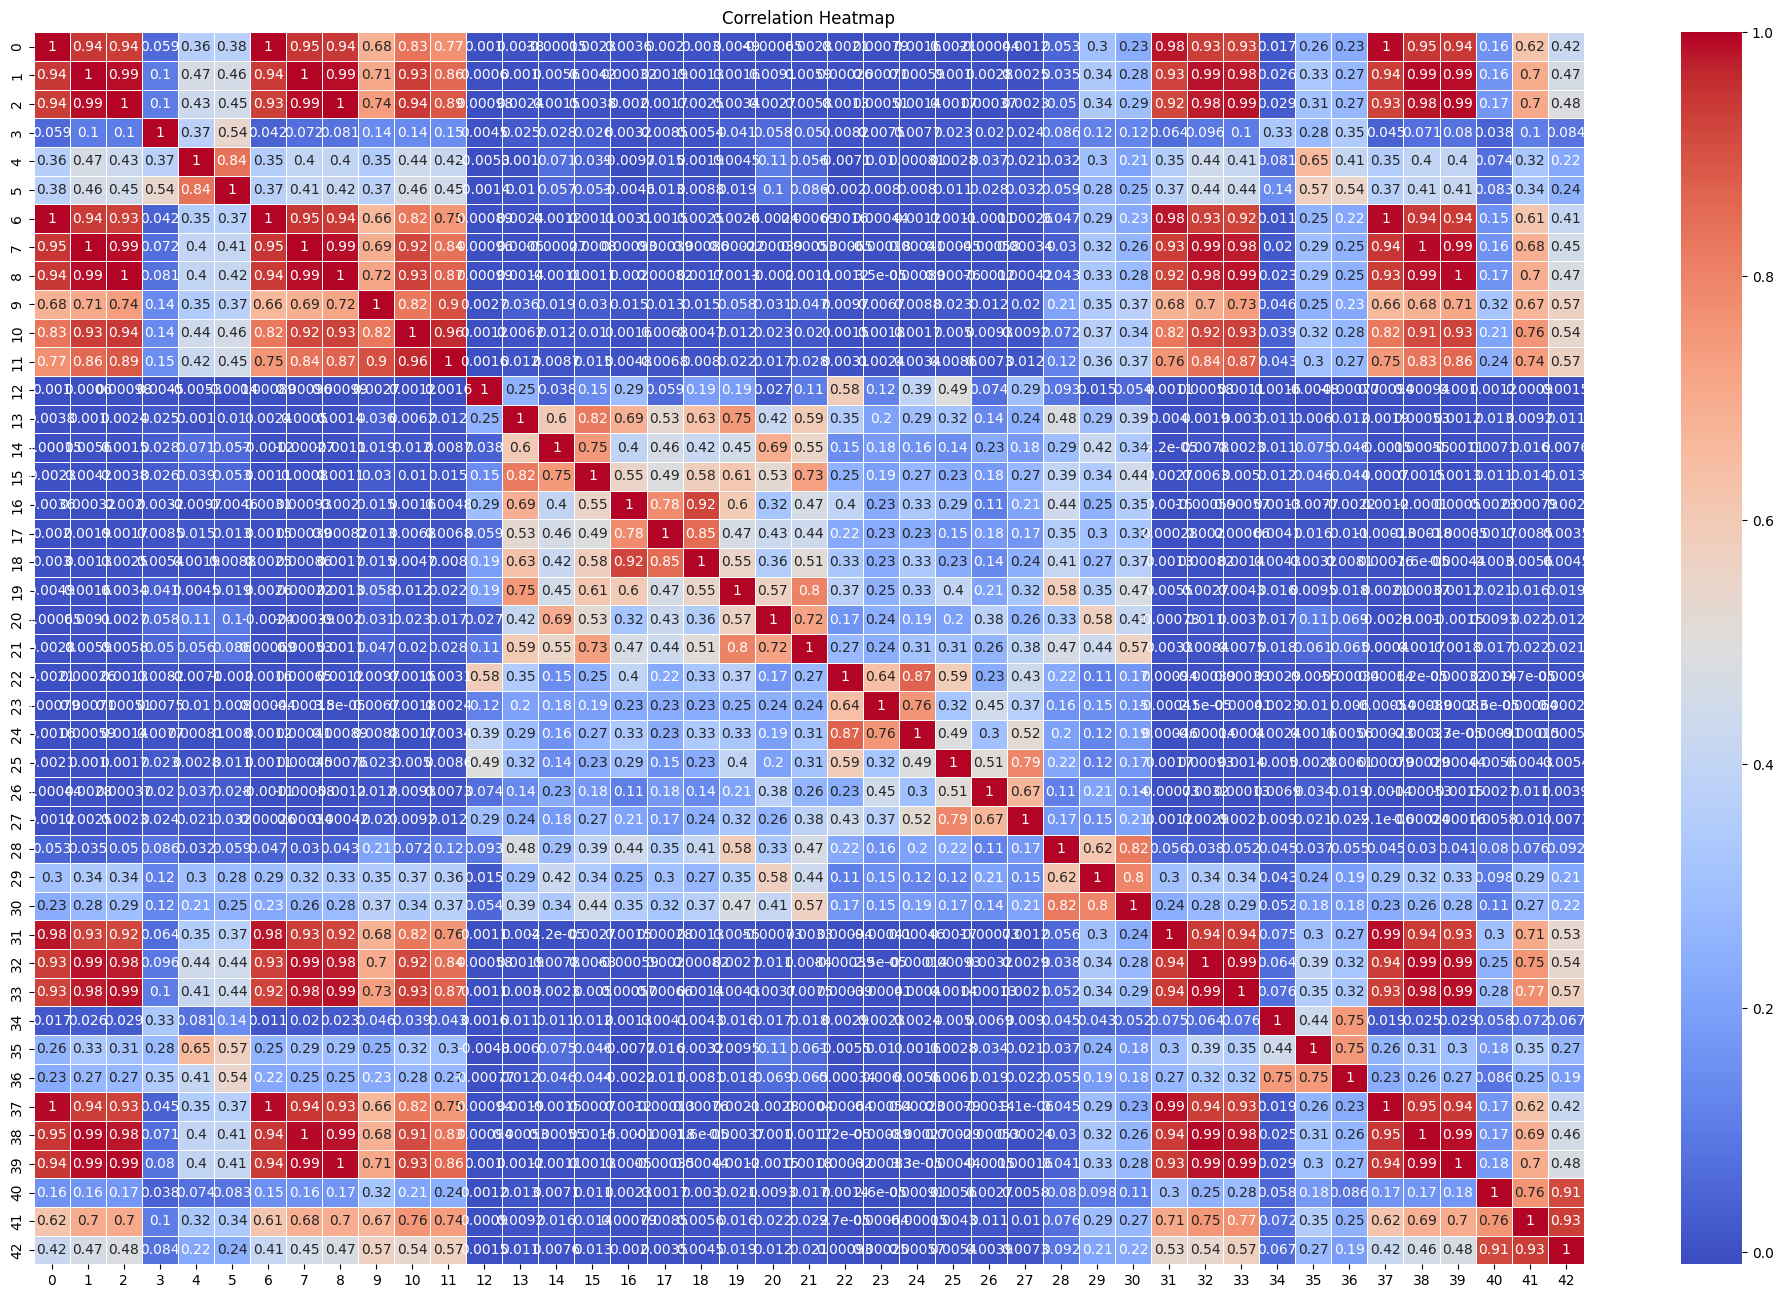

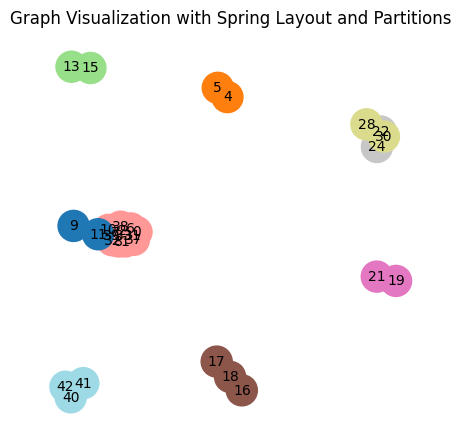

____________________________________________________________________________________________________
2 11 cols
['V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']


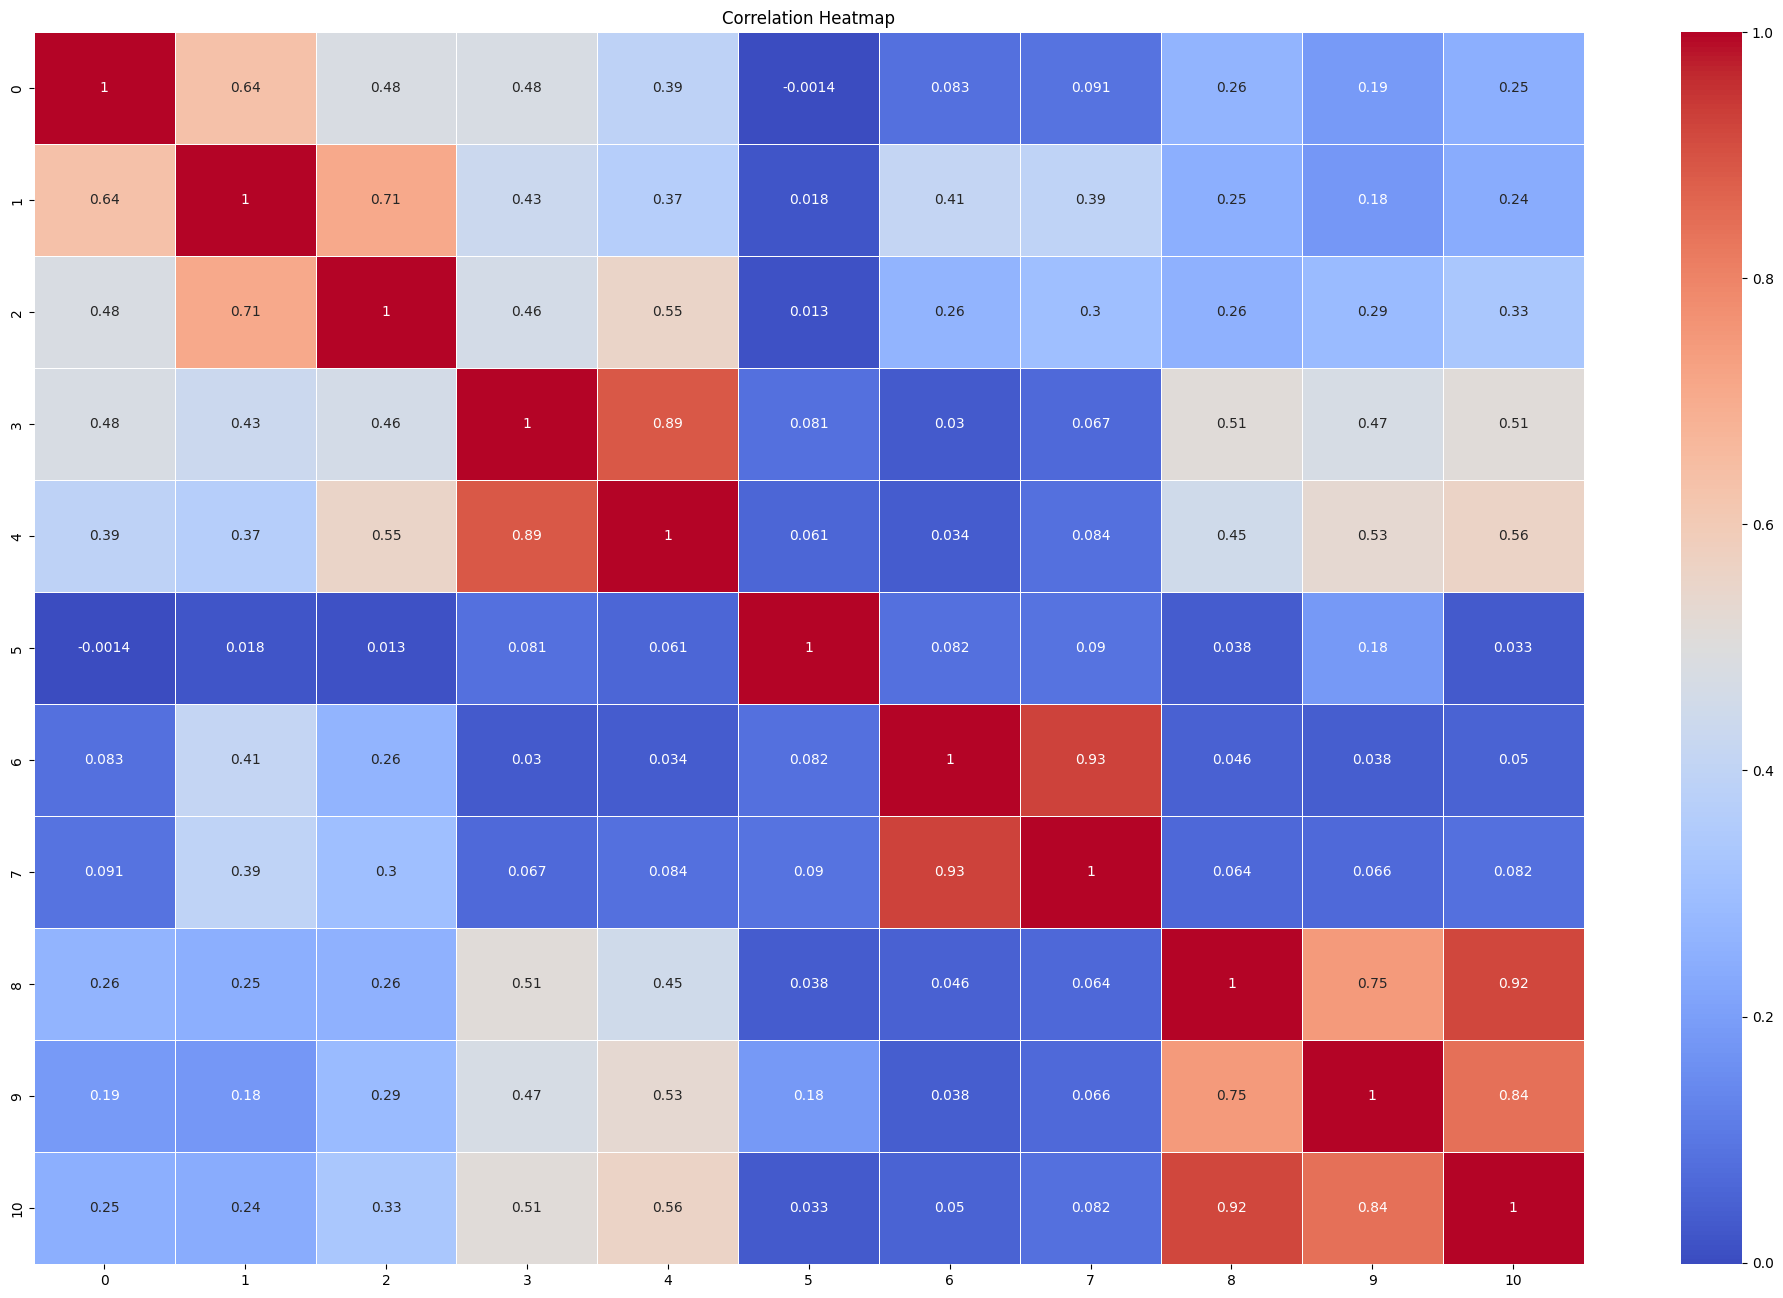

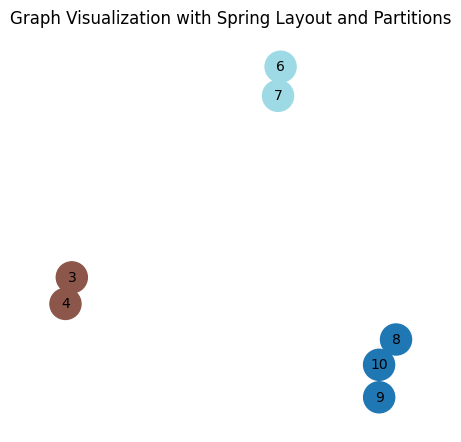

____________________________________________________________________________________________________
3 23 cols
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']


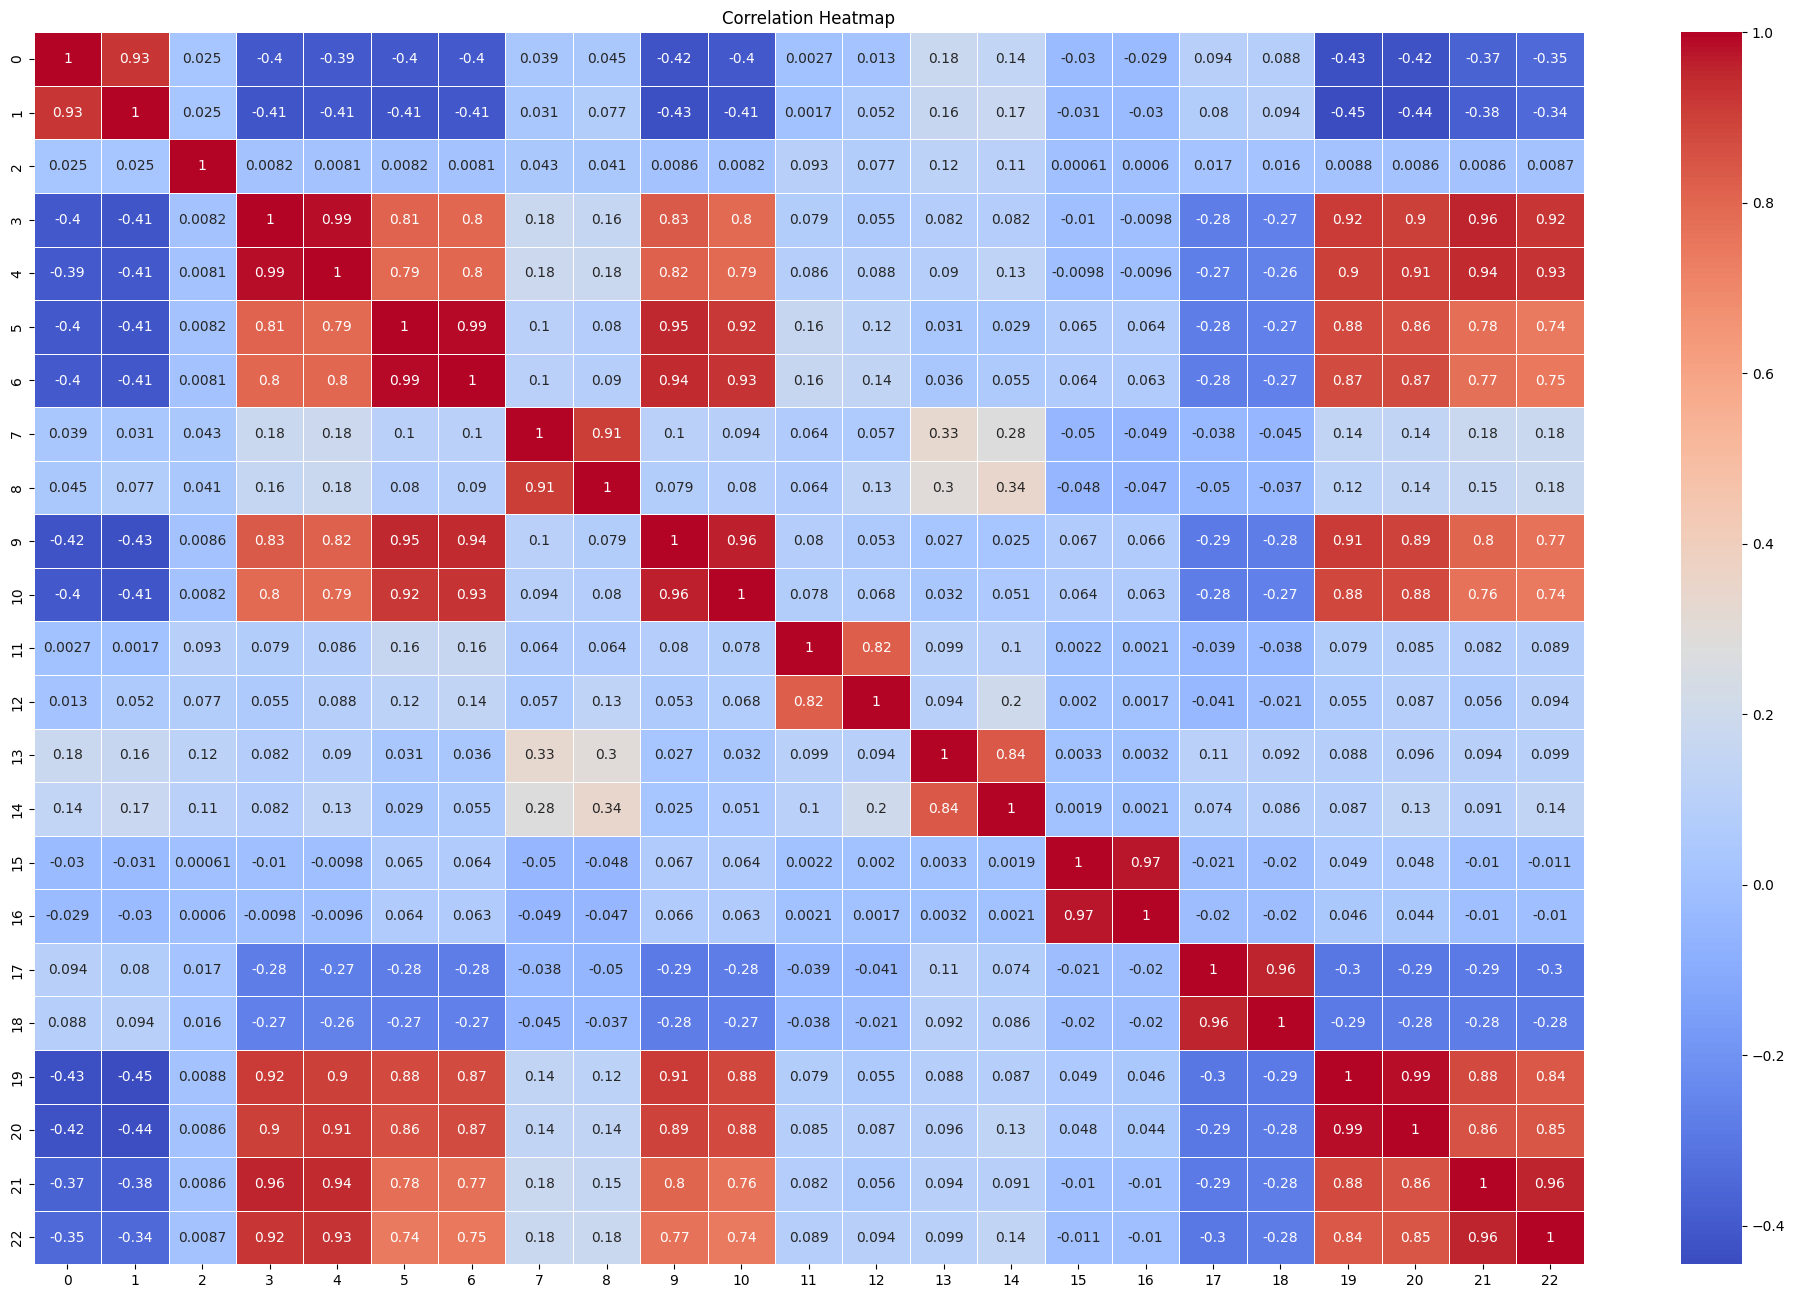

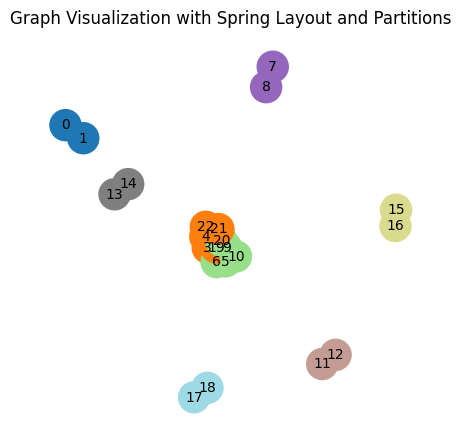

____________________________________________________________________________________________________
4 22 cols
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']


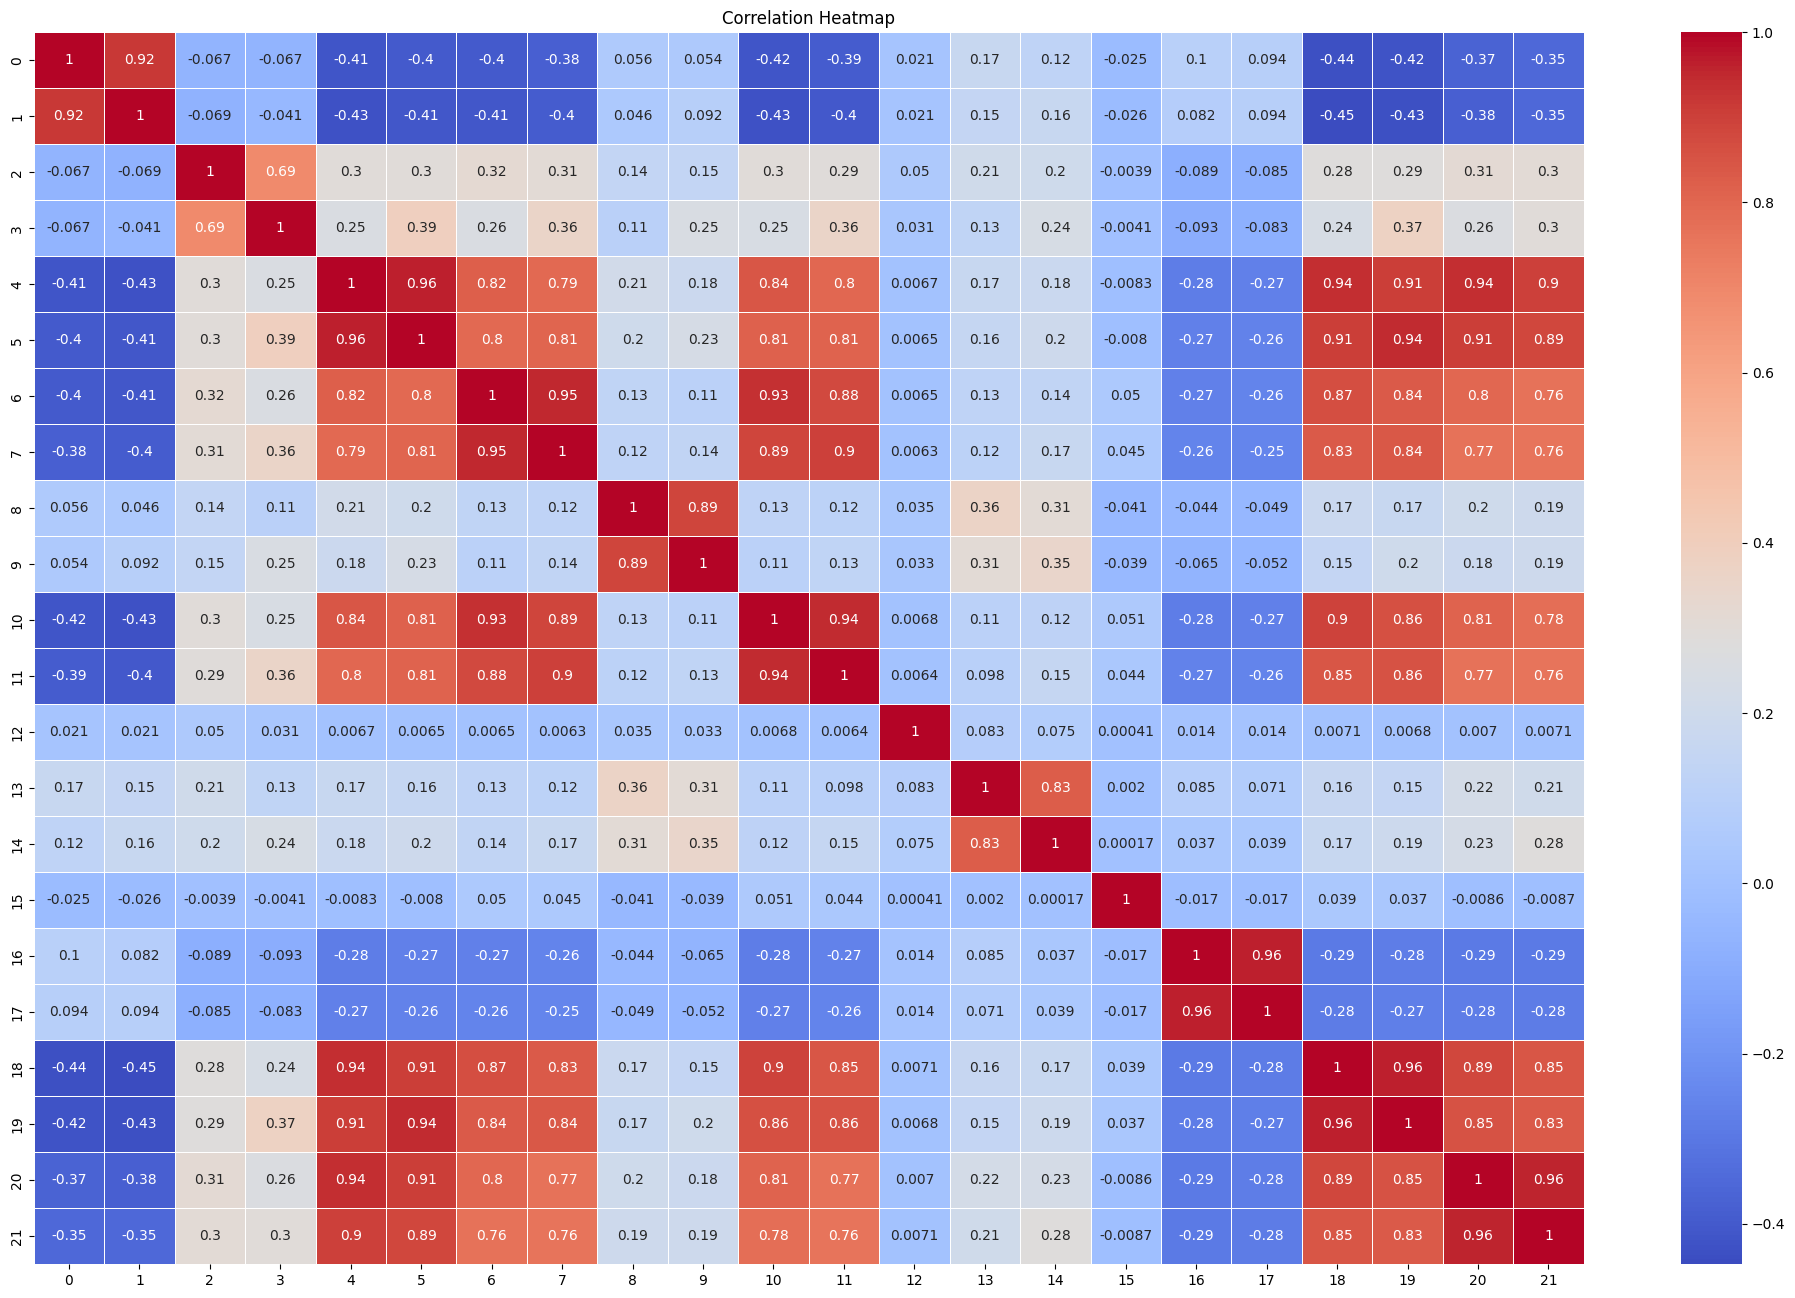

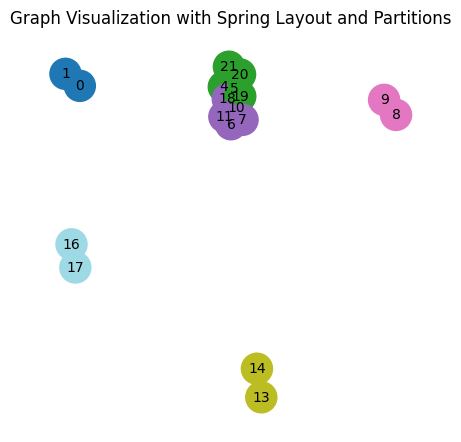

____________________________________________________________________________________________________
5 20 cols
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']


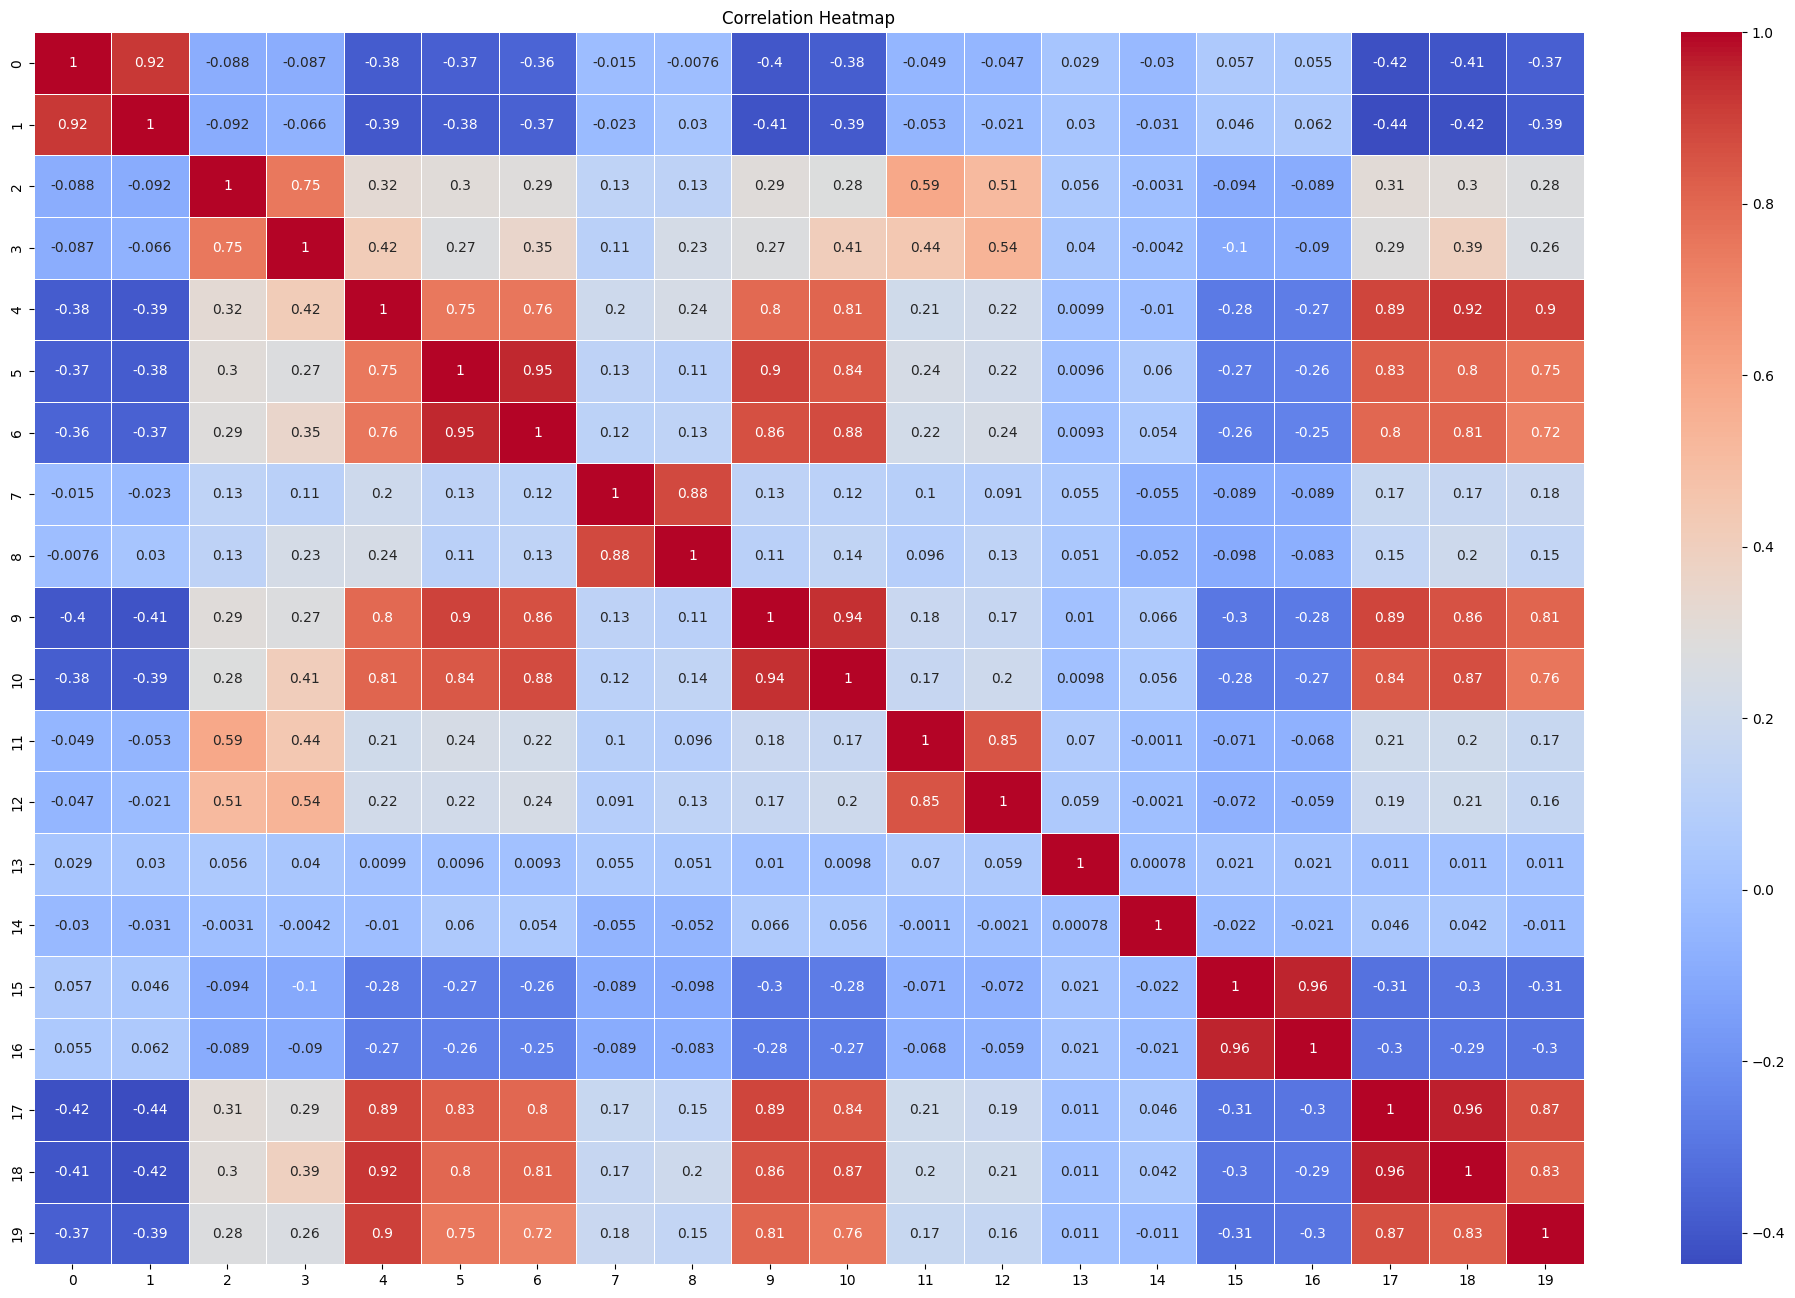

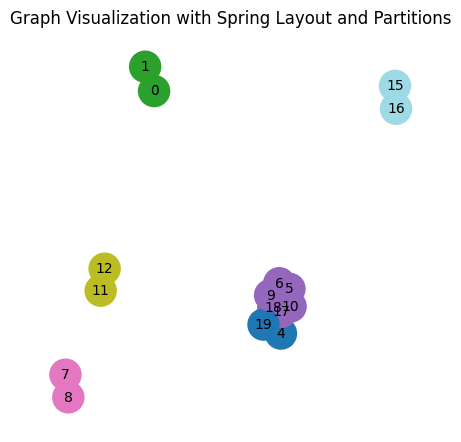

____________________________________________________________________________________________________
6 18 cols
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']


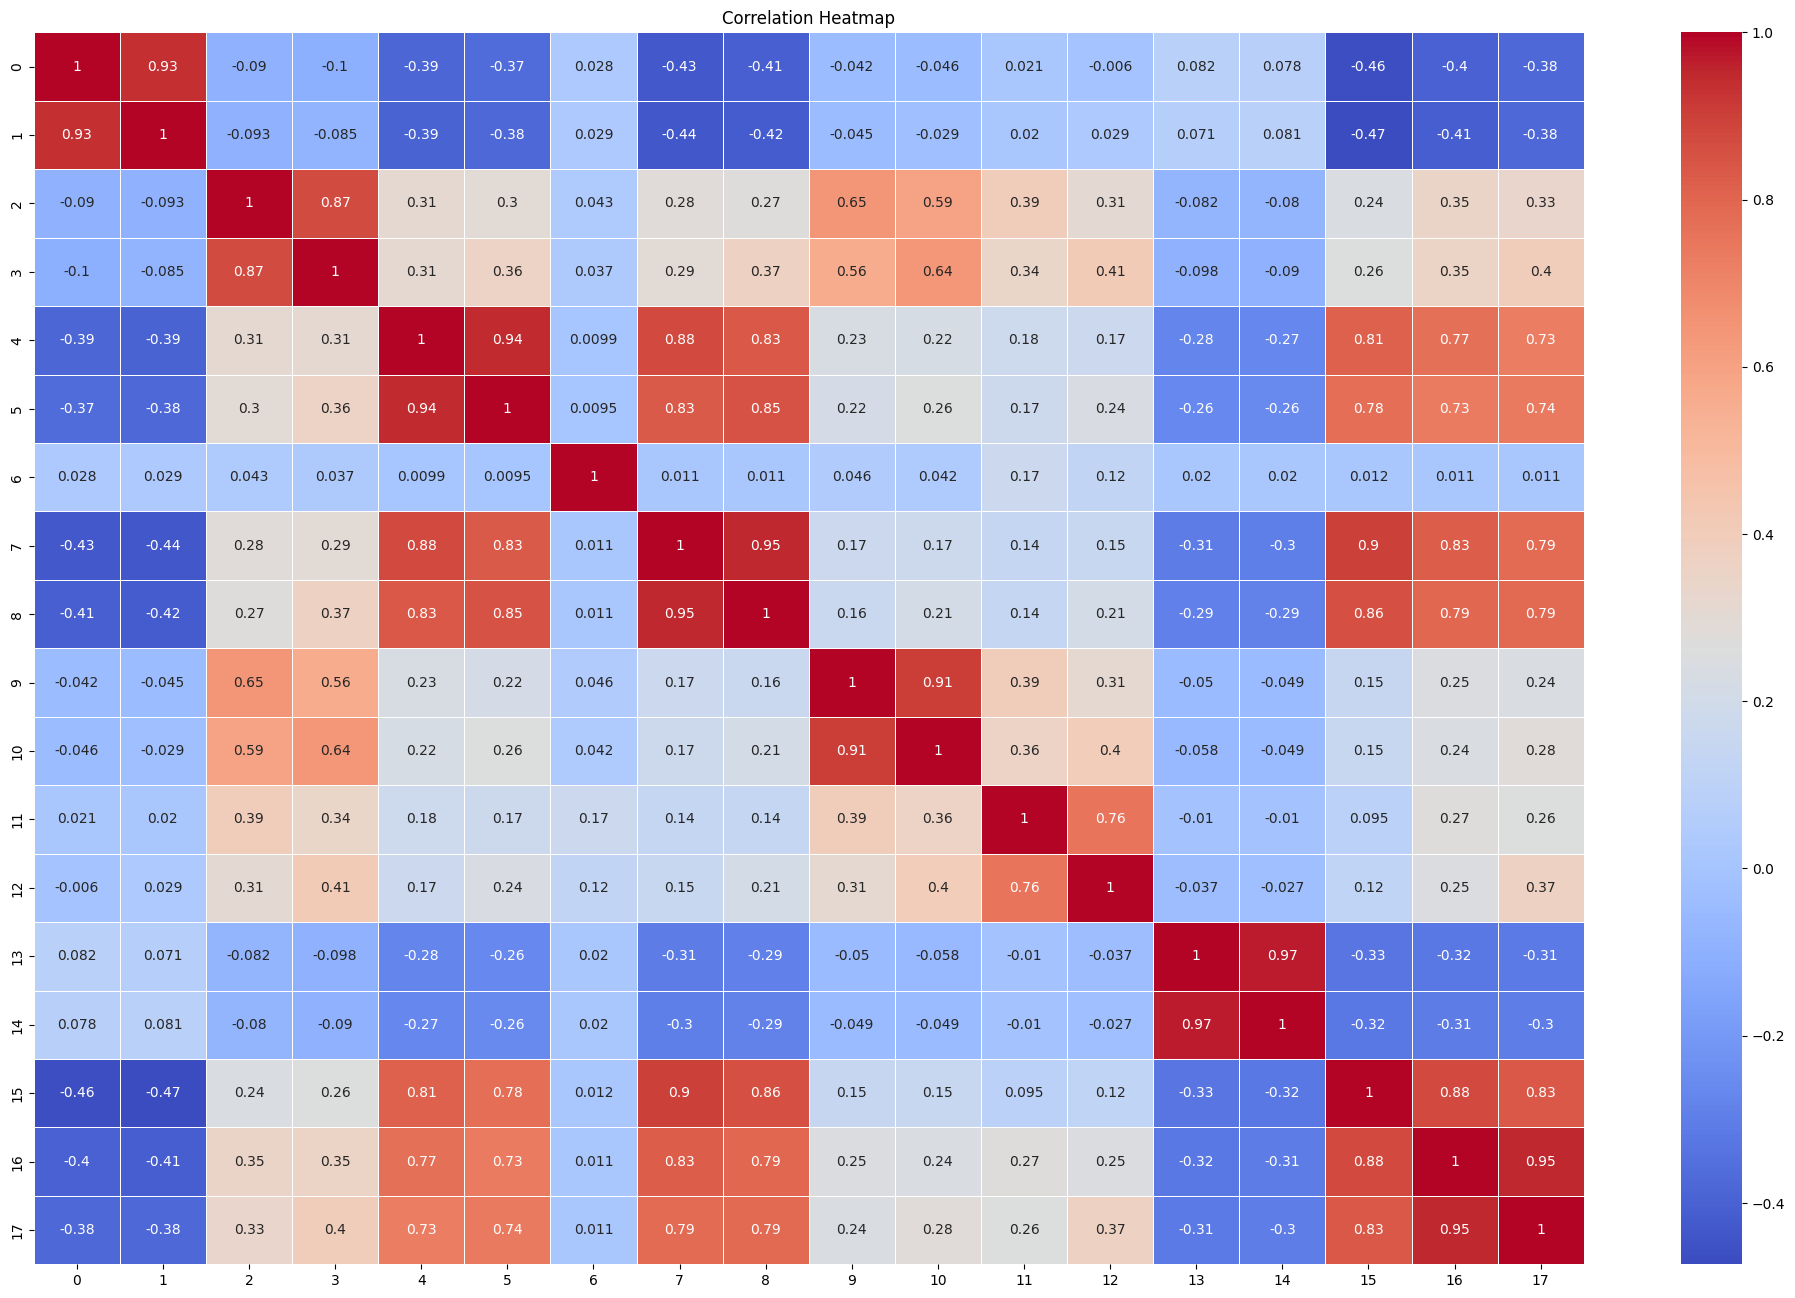

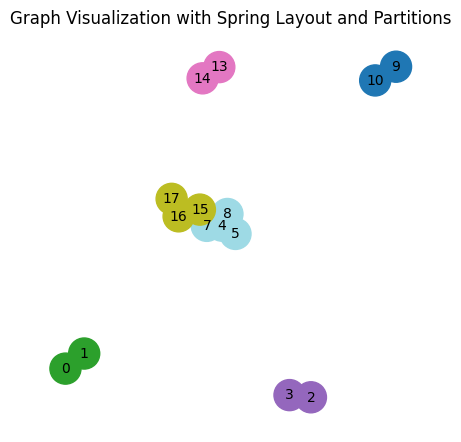

____________________________________________________________________________________________________
7 11 cols
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']


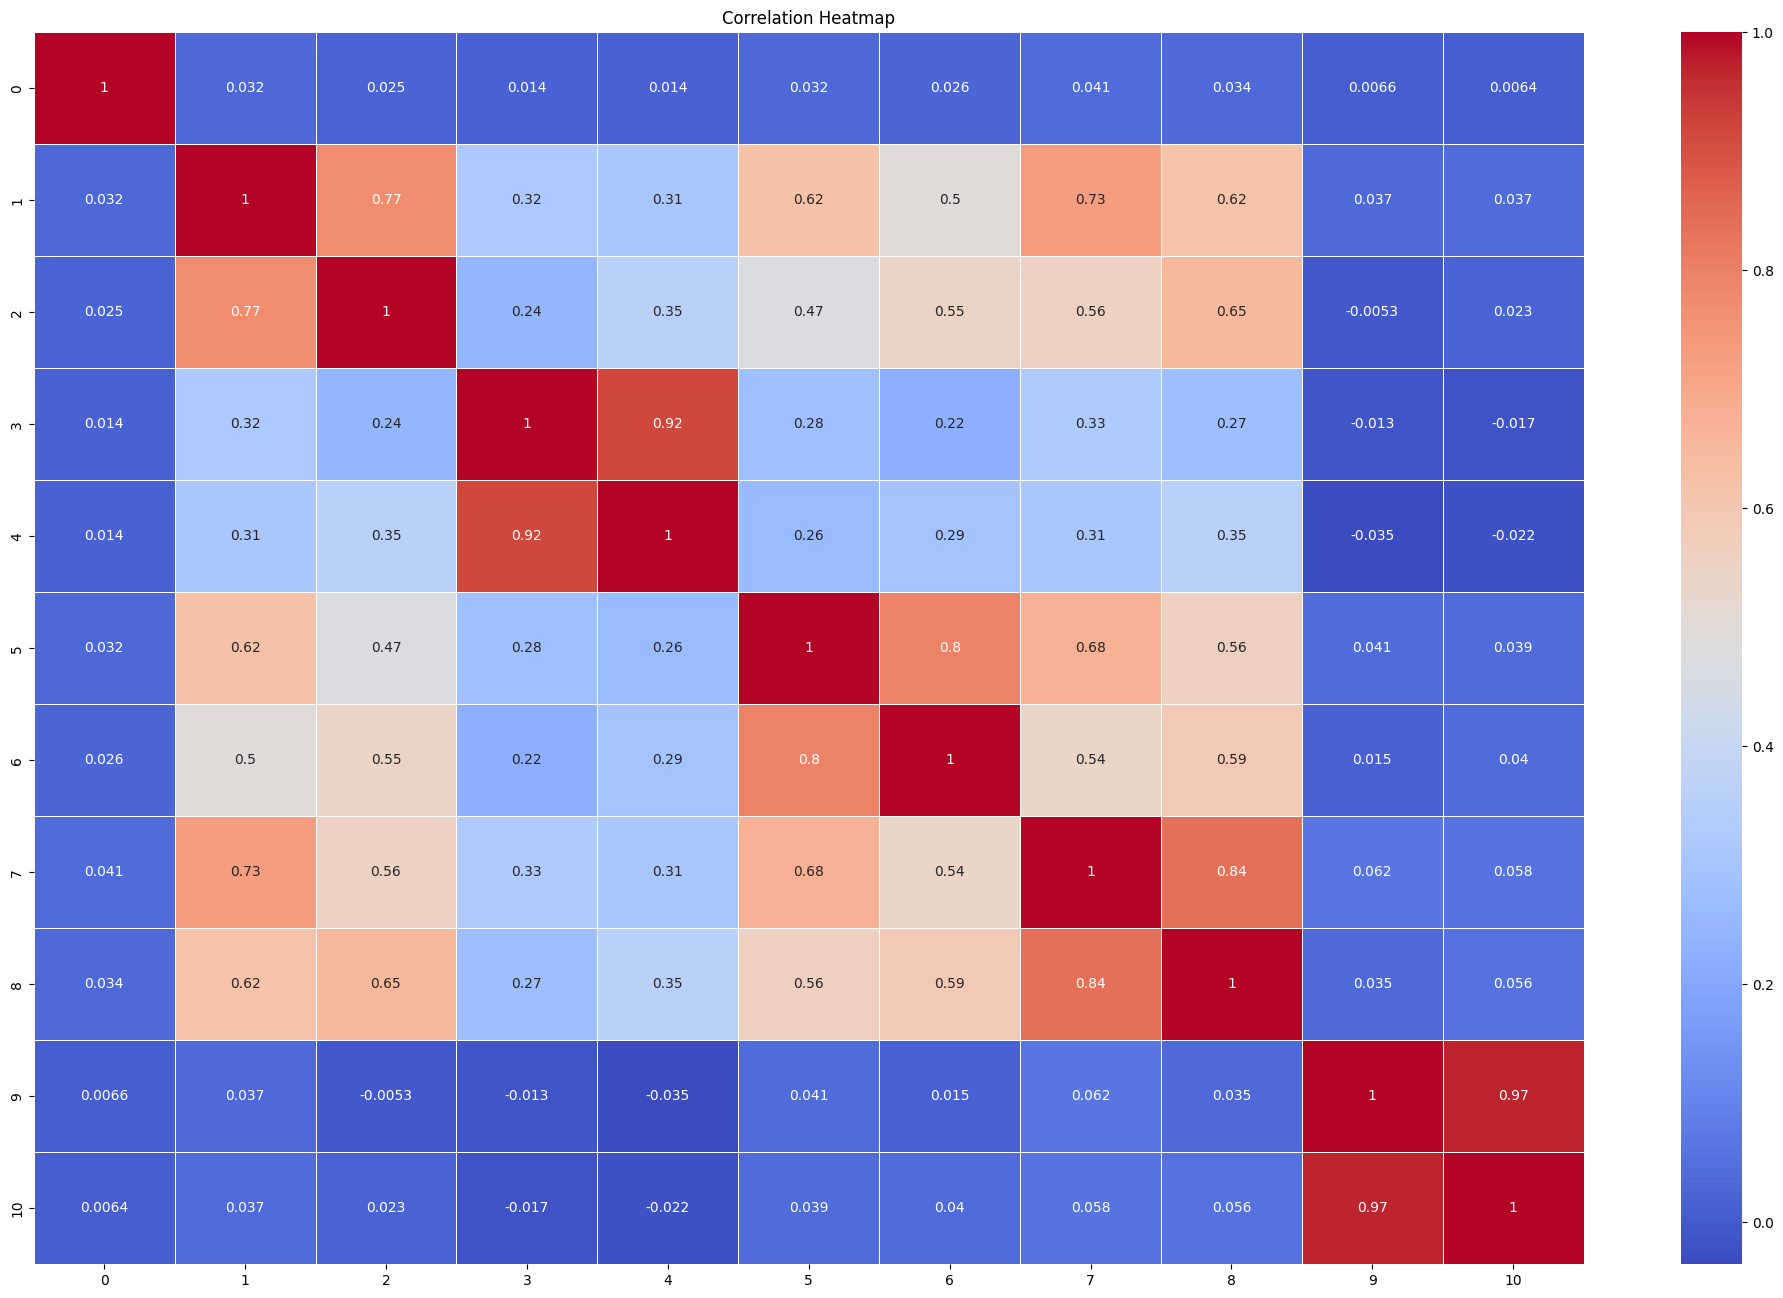

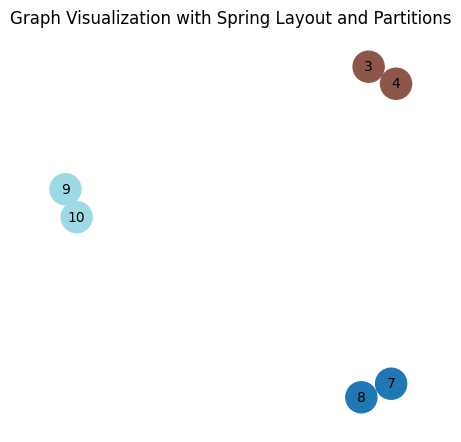

____________________________________________________________________________________________________
8 16 cols
['V220', 'V221', 'V222', 'V227', 'V234', 'V238', 'V239', 'V245', 'V250', 'V251', 'V255', 'V256', 'V259', 'V270', 'V271', 'V272']


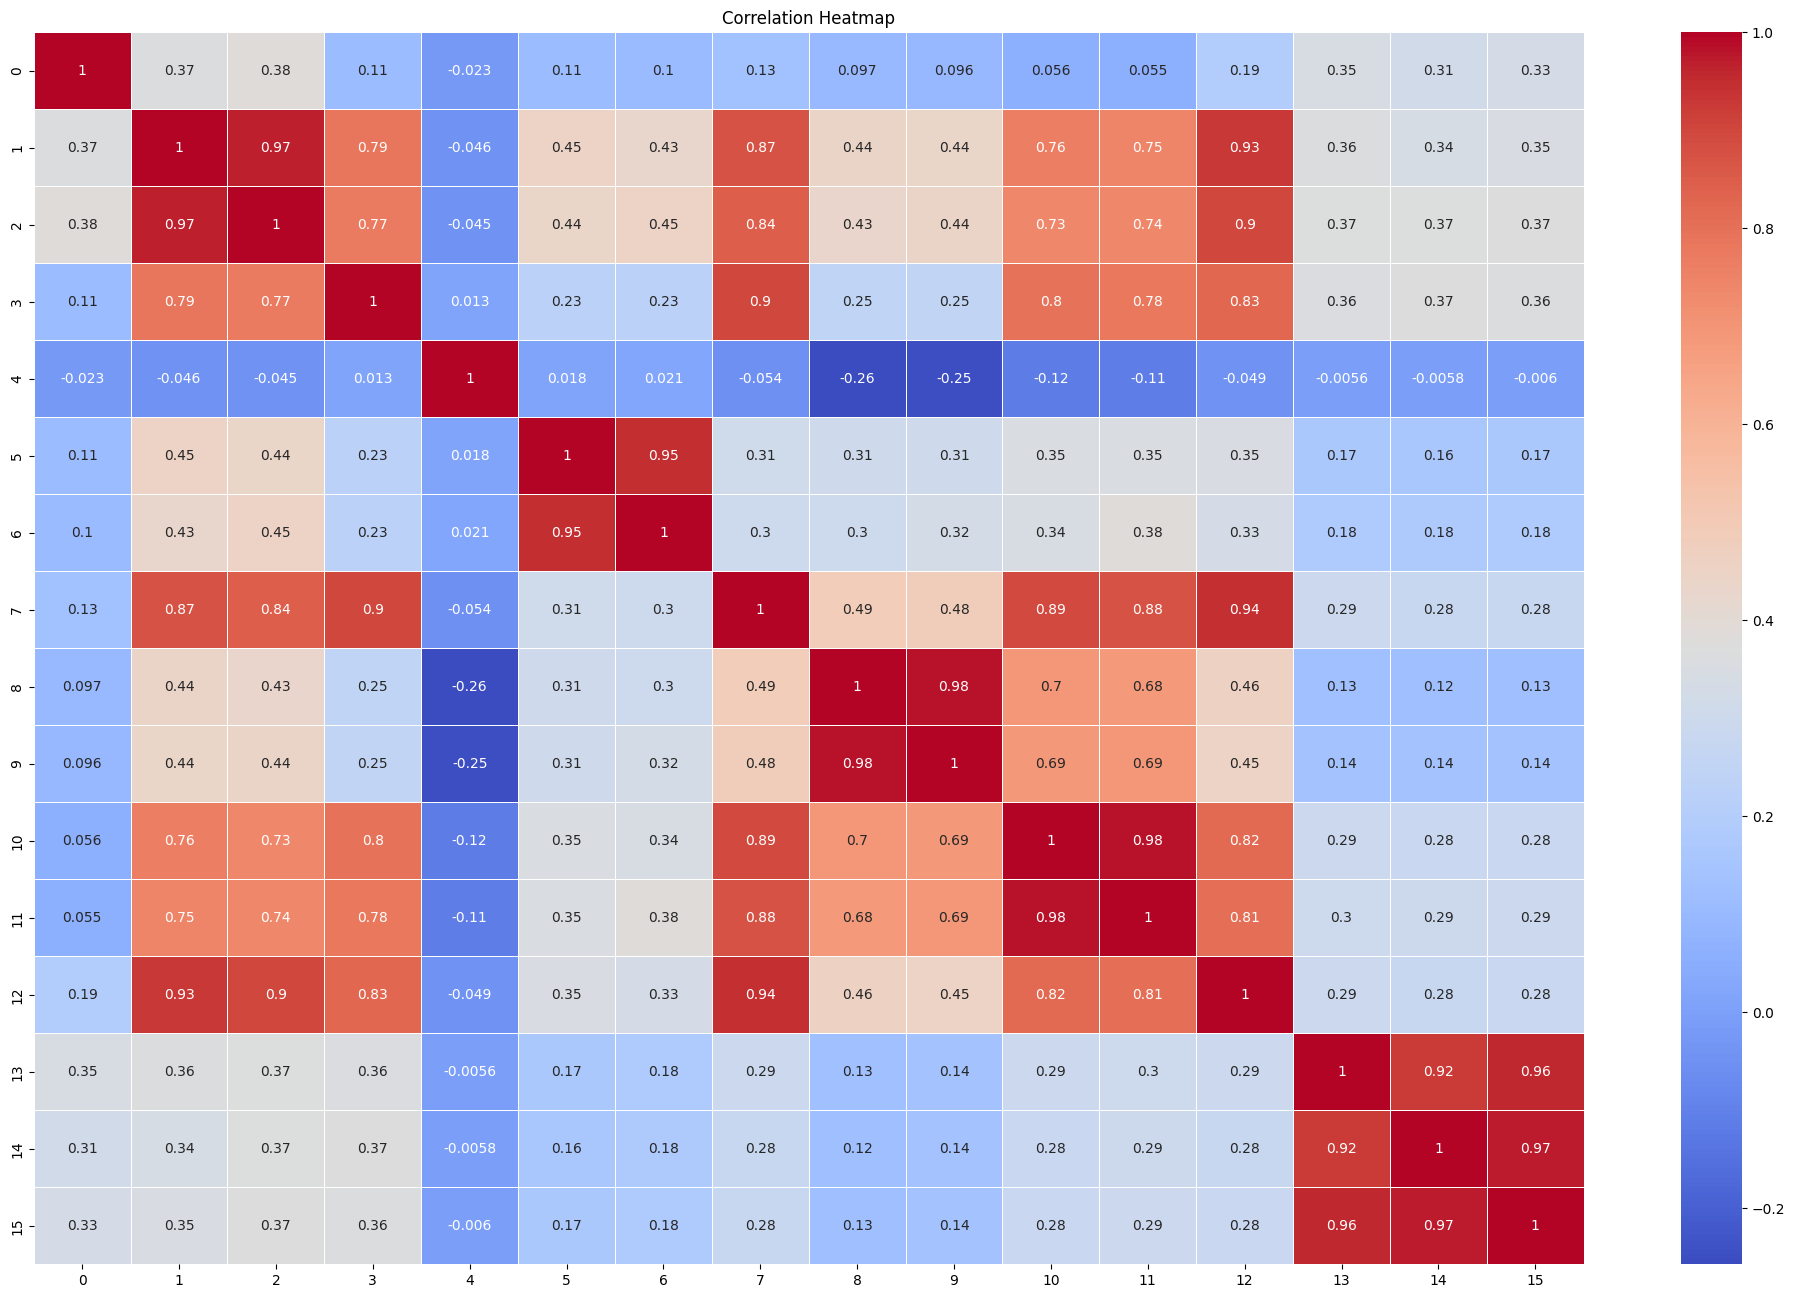

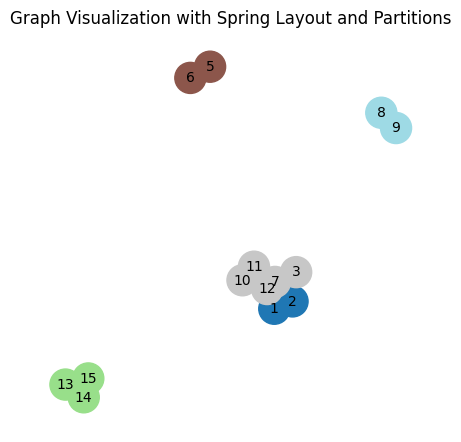

____________________________________________________________________________________________________
9 19 cols
['V169', 'V170', 'V171', 'V174', 'V175', 'V180', 'V184', 'V185', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V208', 'V209', 'V210']


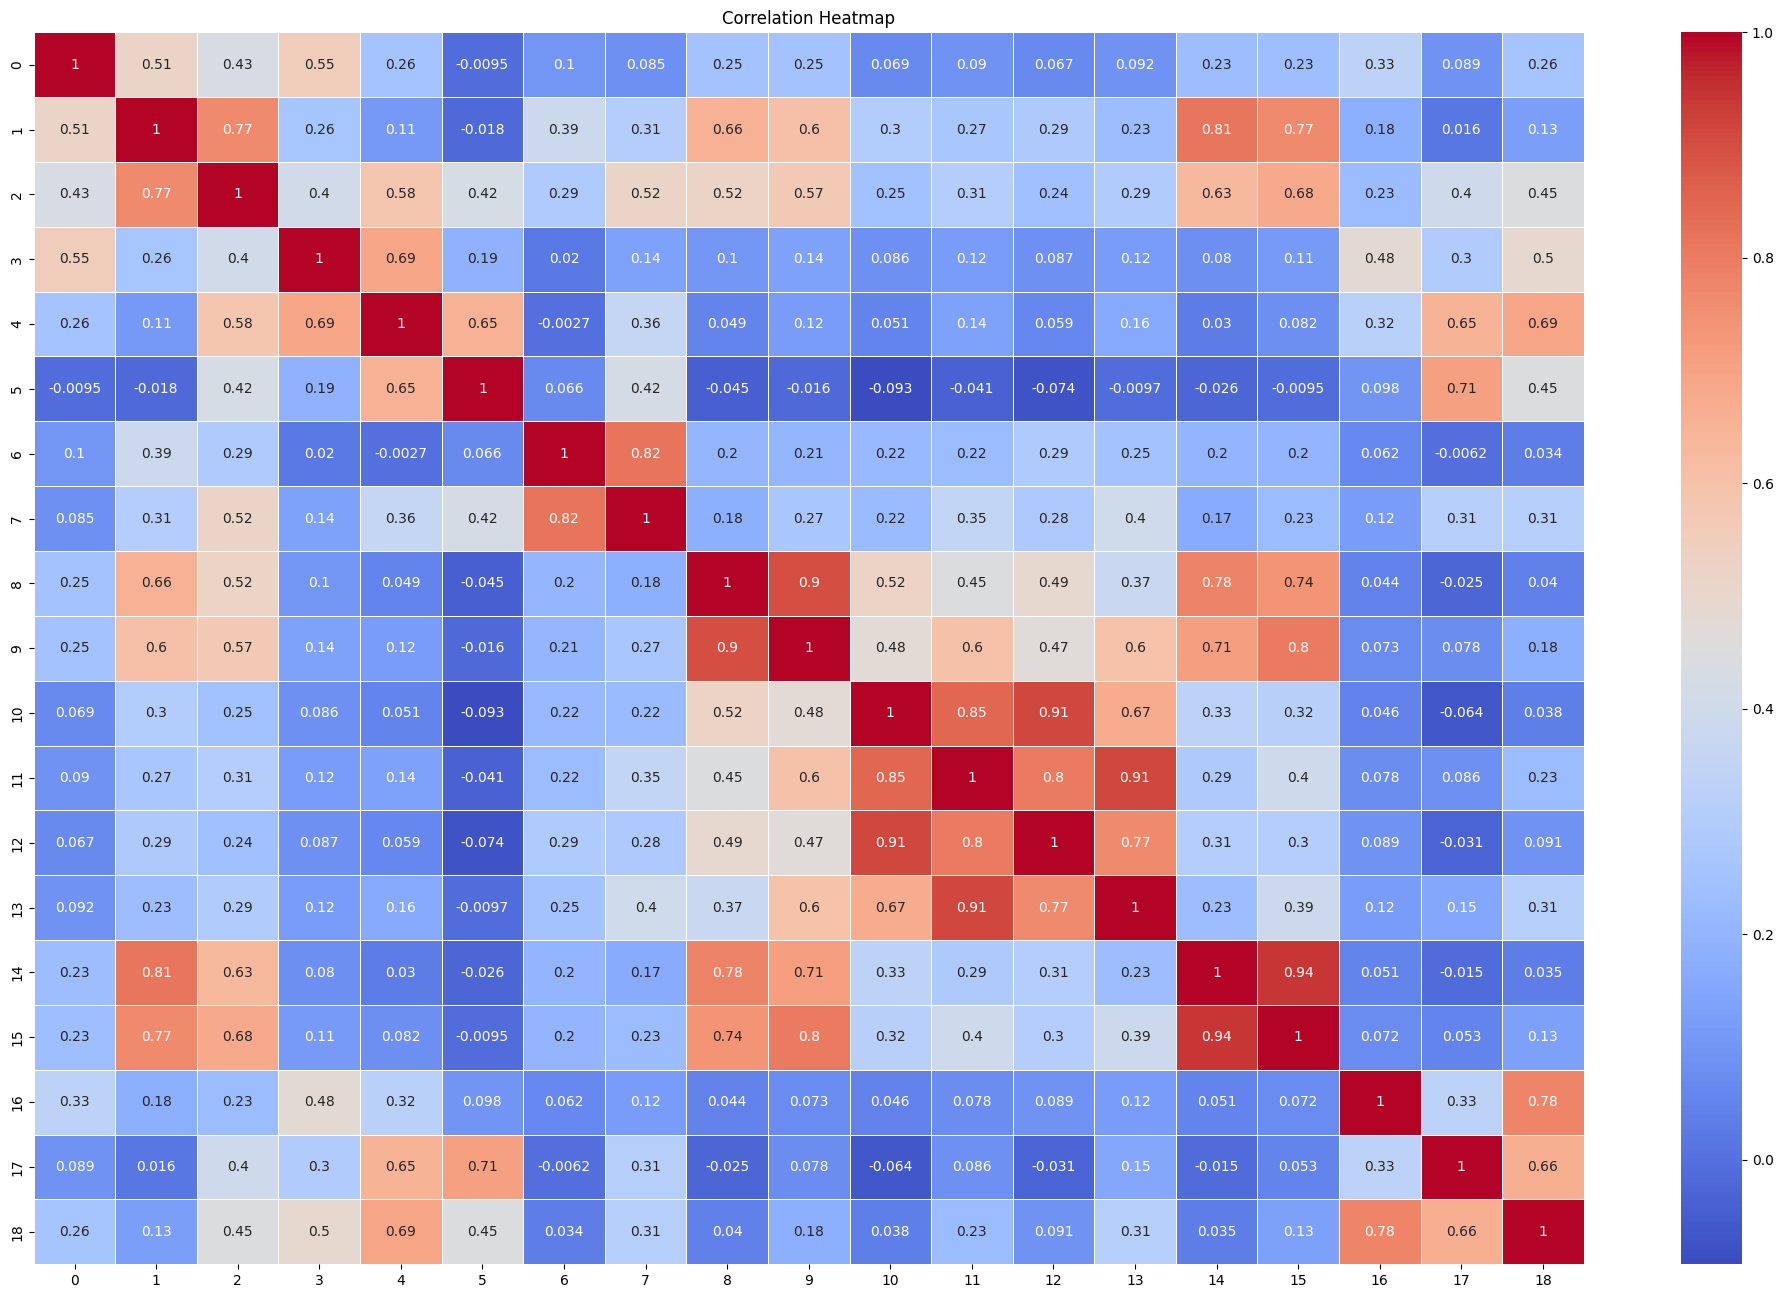

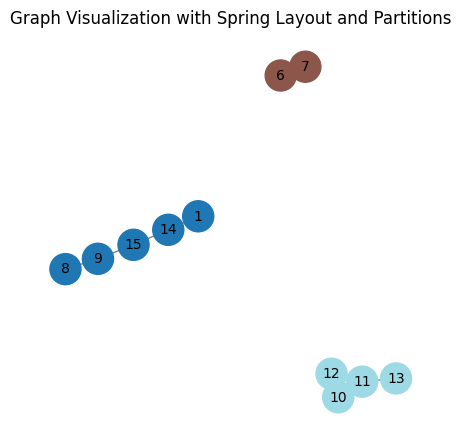

____________________________________________________________________________________________________
10 31 cols
['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216']


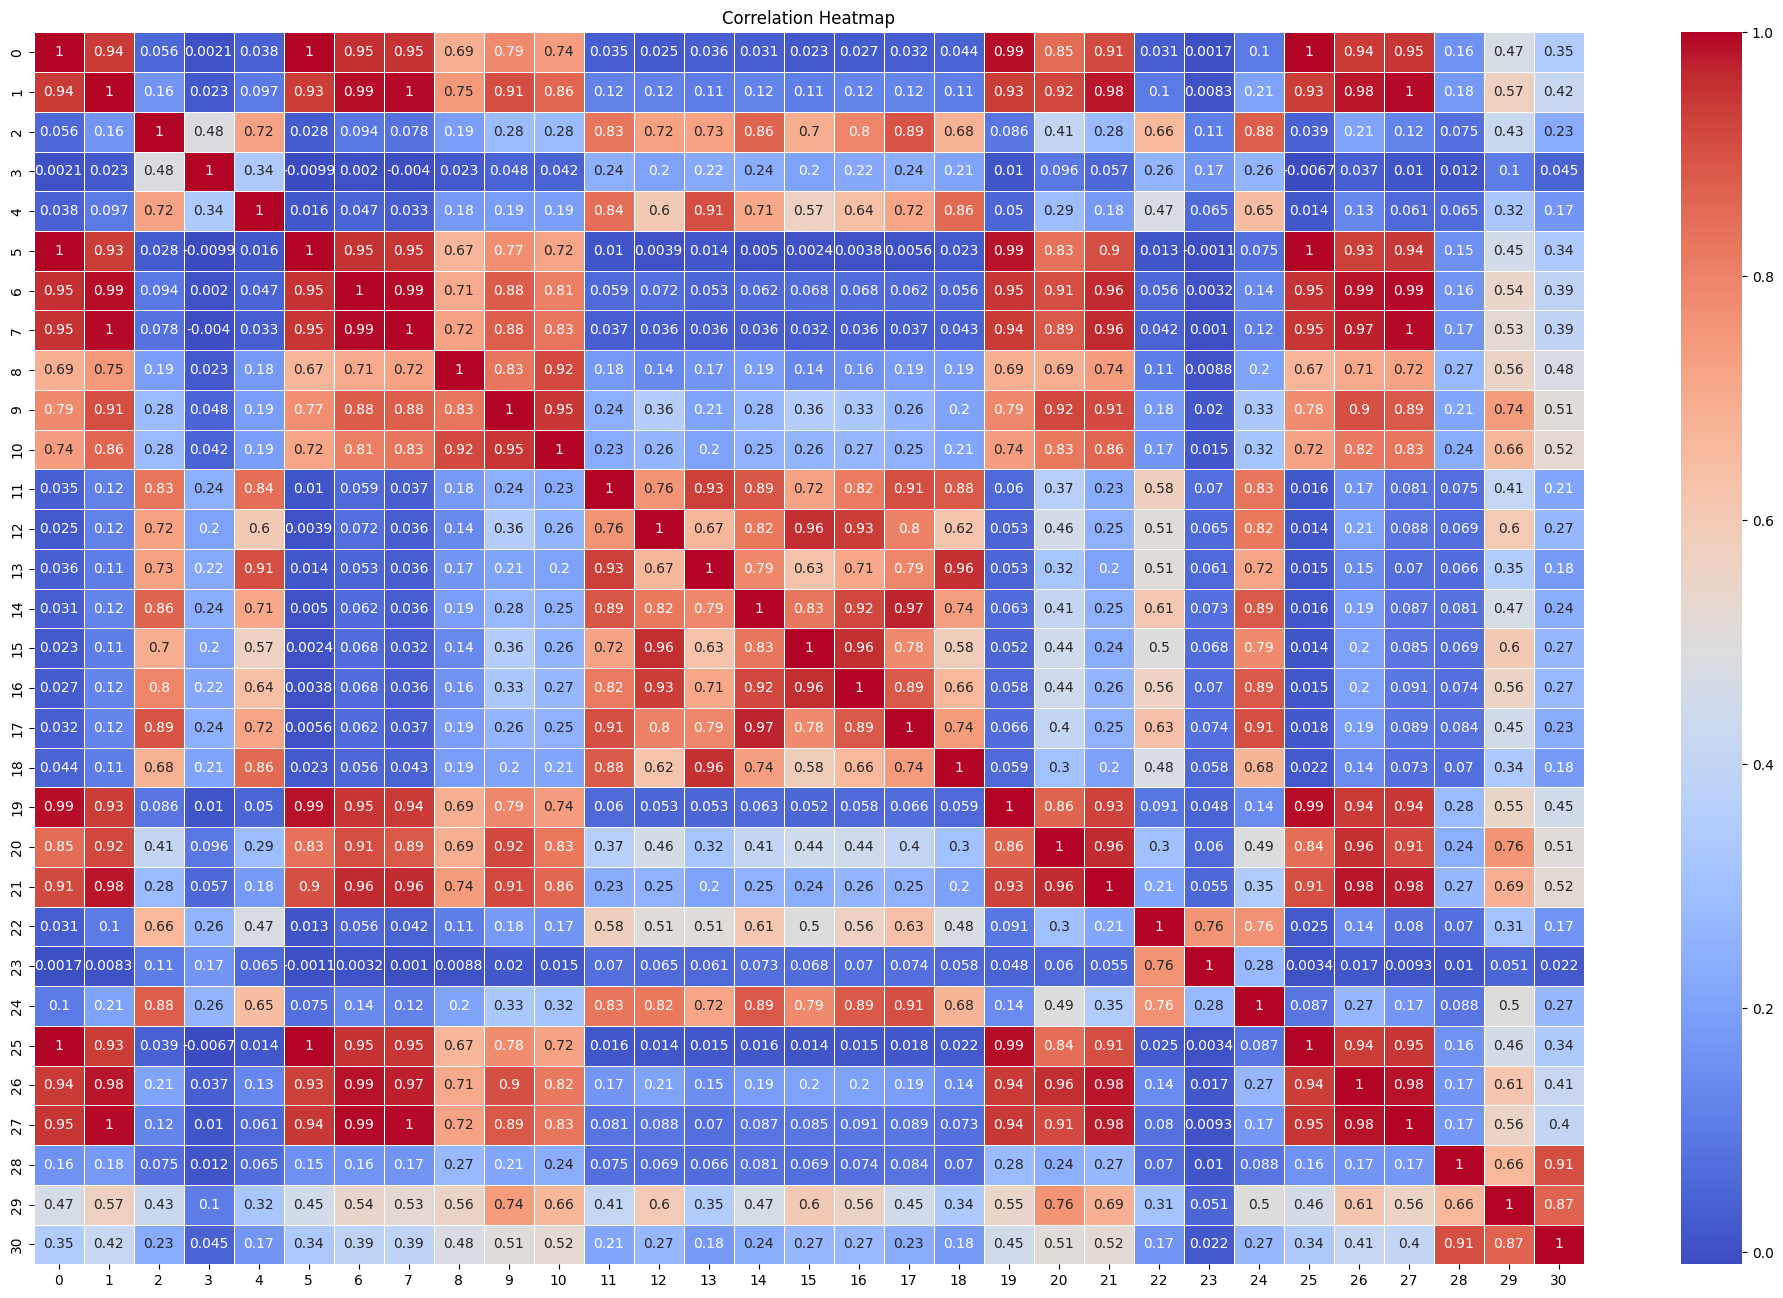

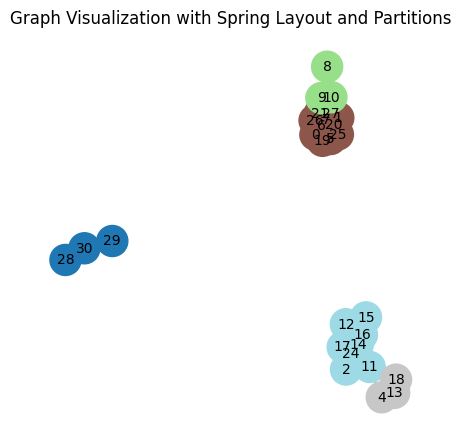

____________________________________________________________________________________________________
11 46 cols
['V217', 'V218', 'V219', 'V223', 'V224', 'V225', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V240', 'V241', 'V242', 'V243', 'V244', 'V246', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278']


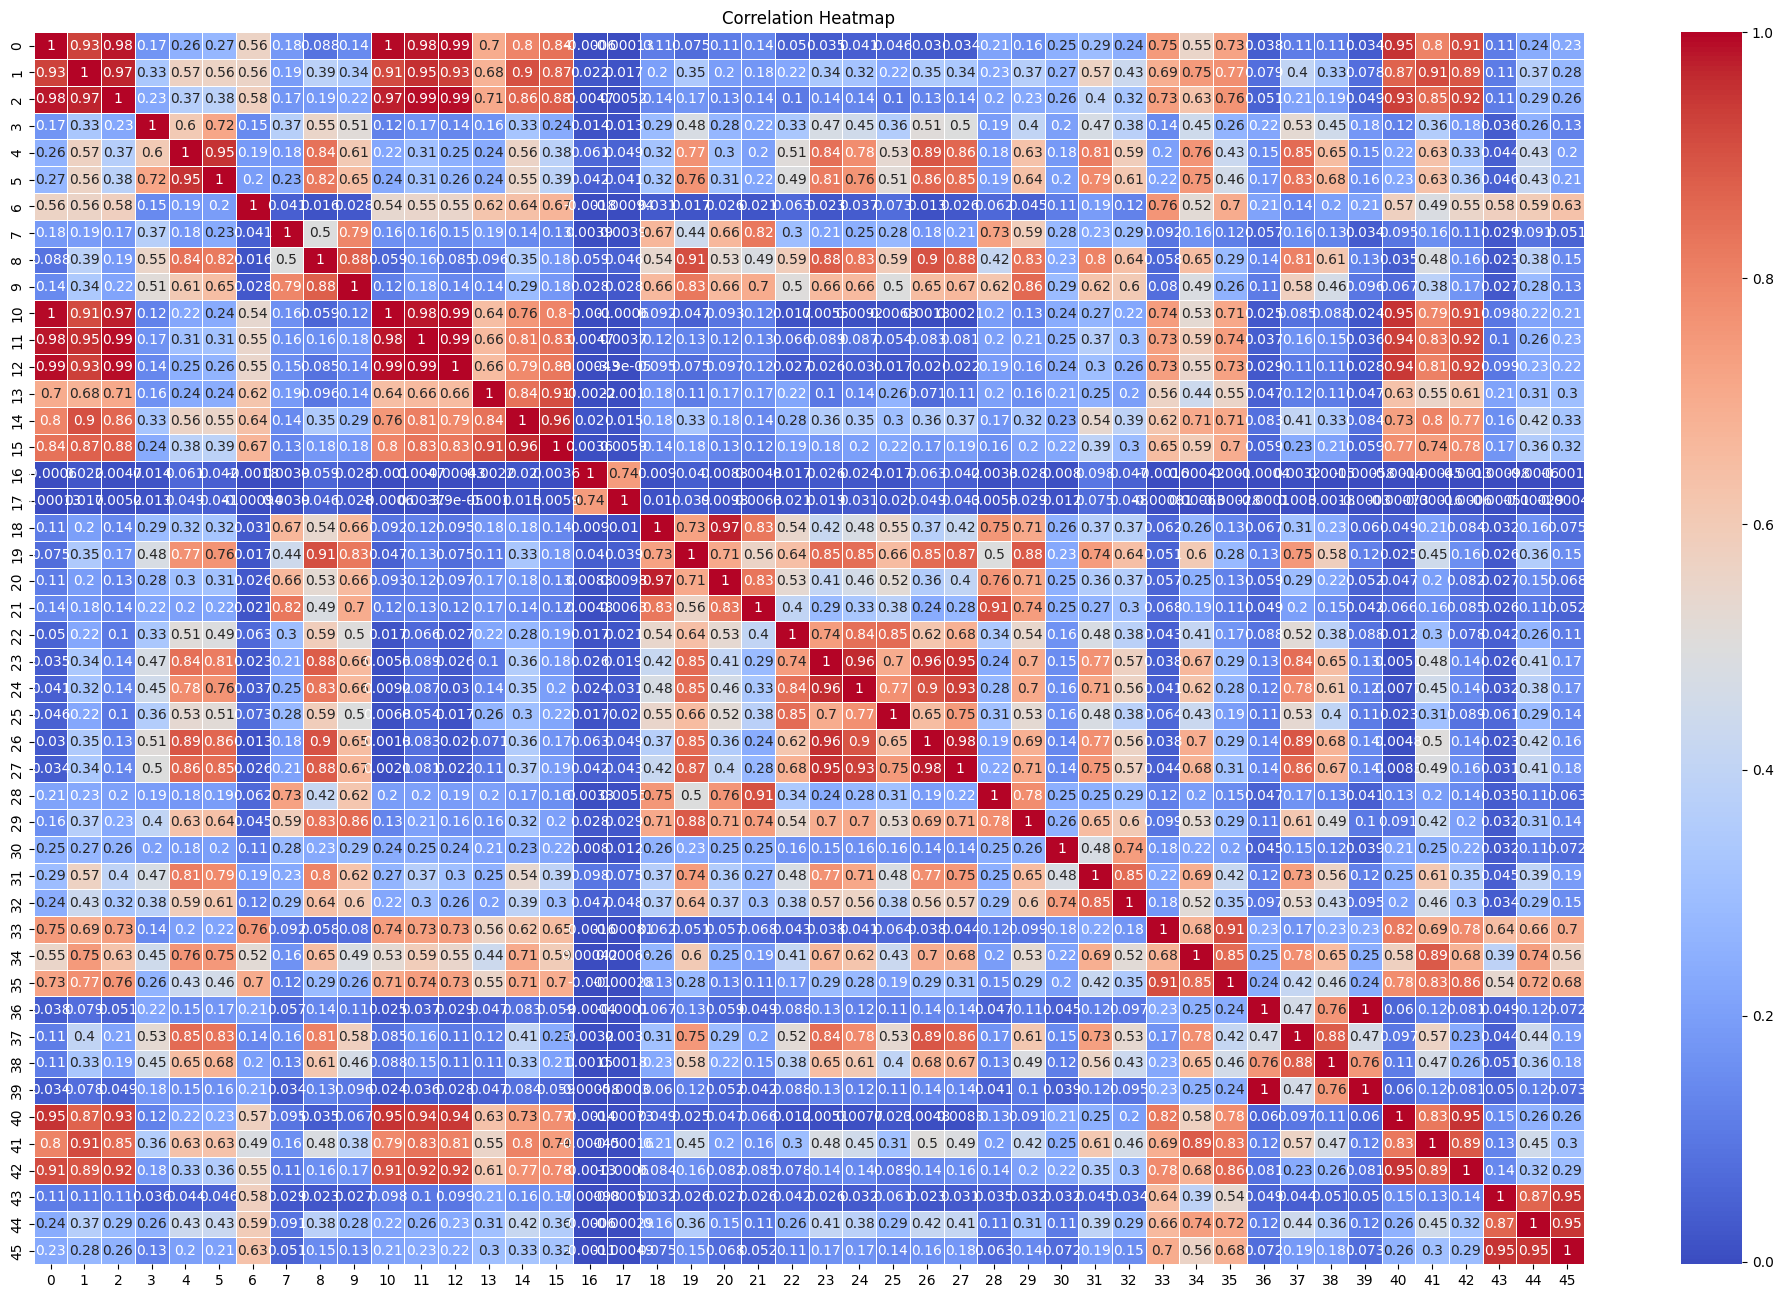

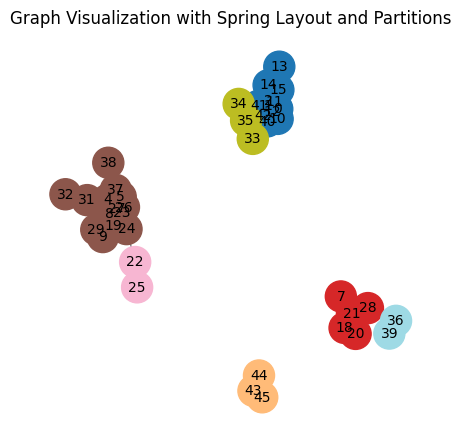

____________________________________________________________________________________________________
12 18 cols
['V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']


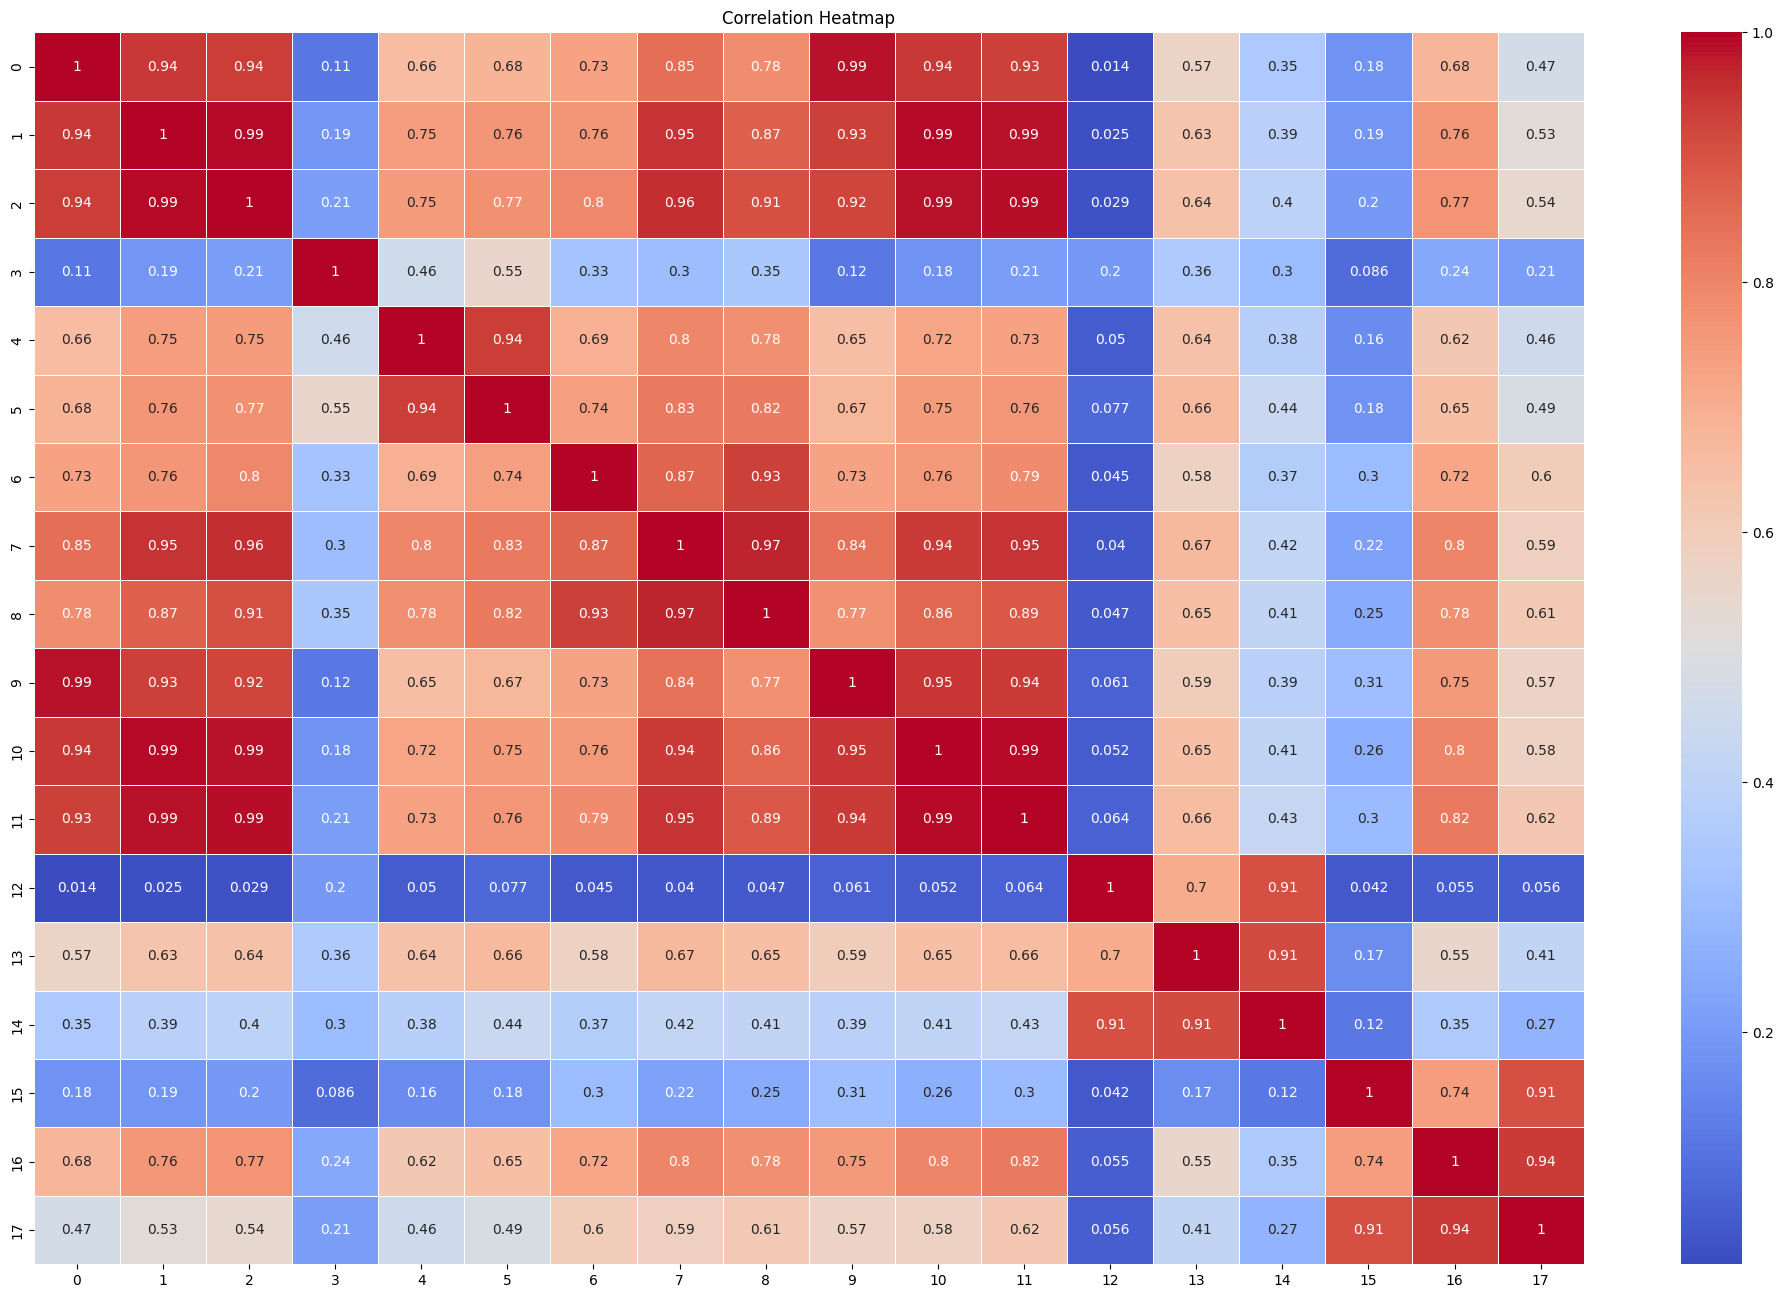

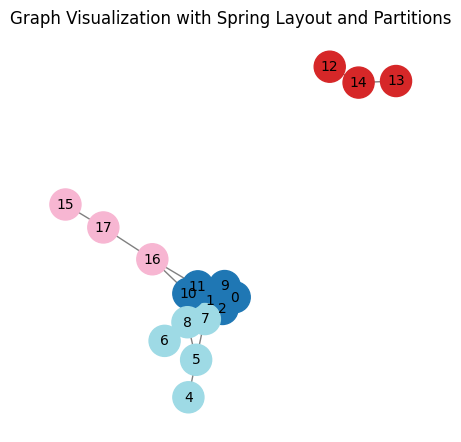

____________________________________________________________________________________________________
13 11 cols
['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']


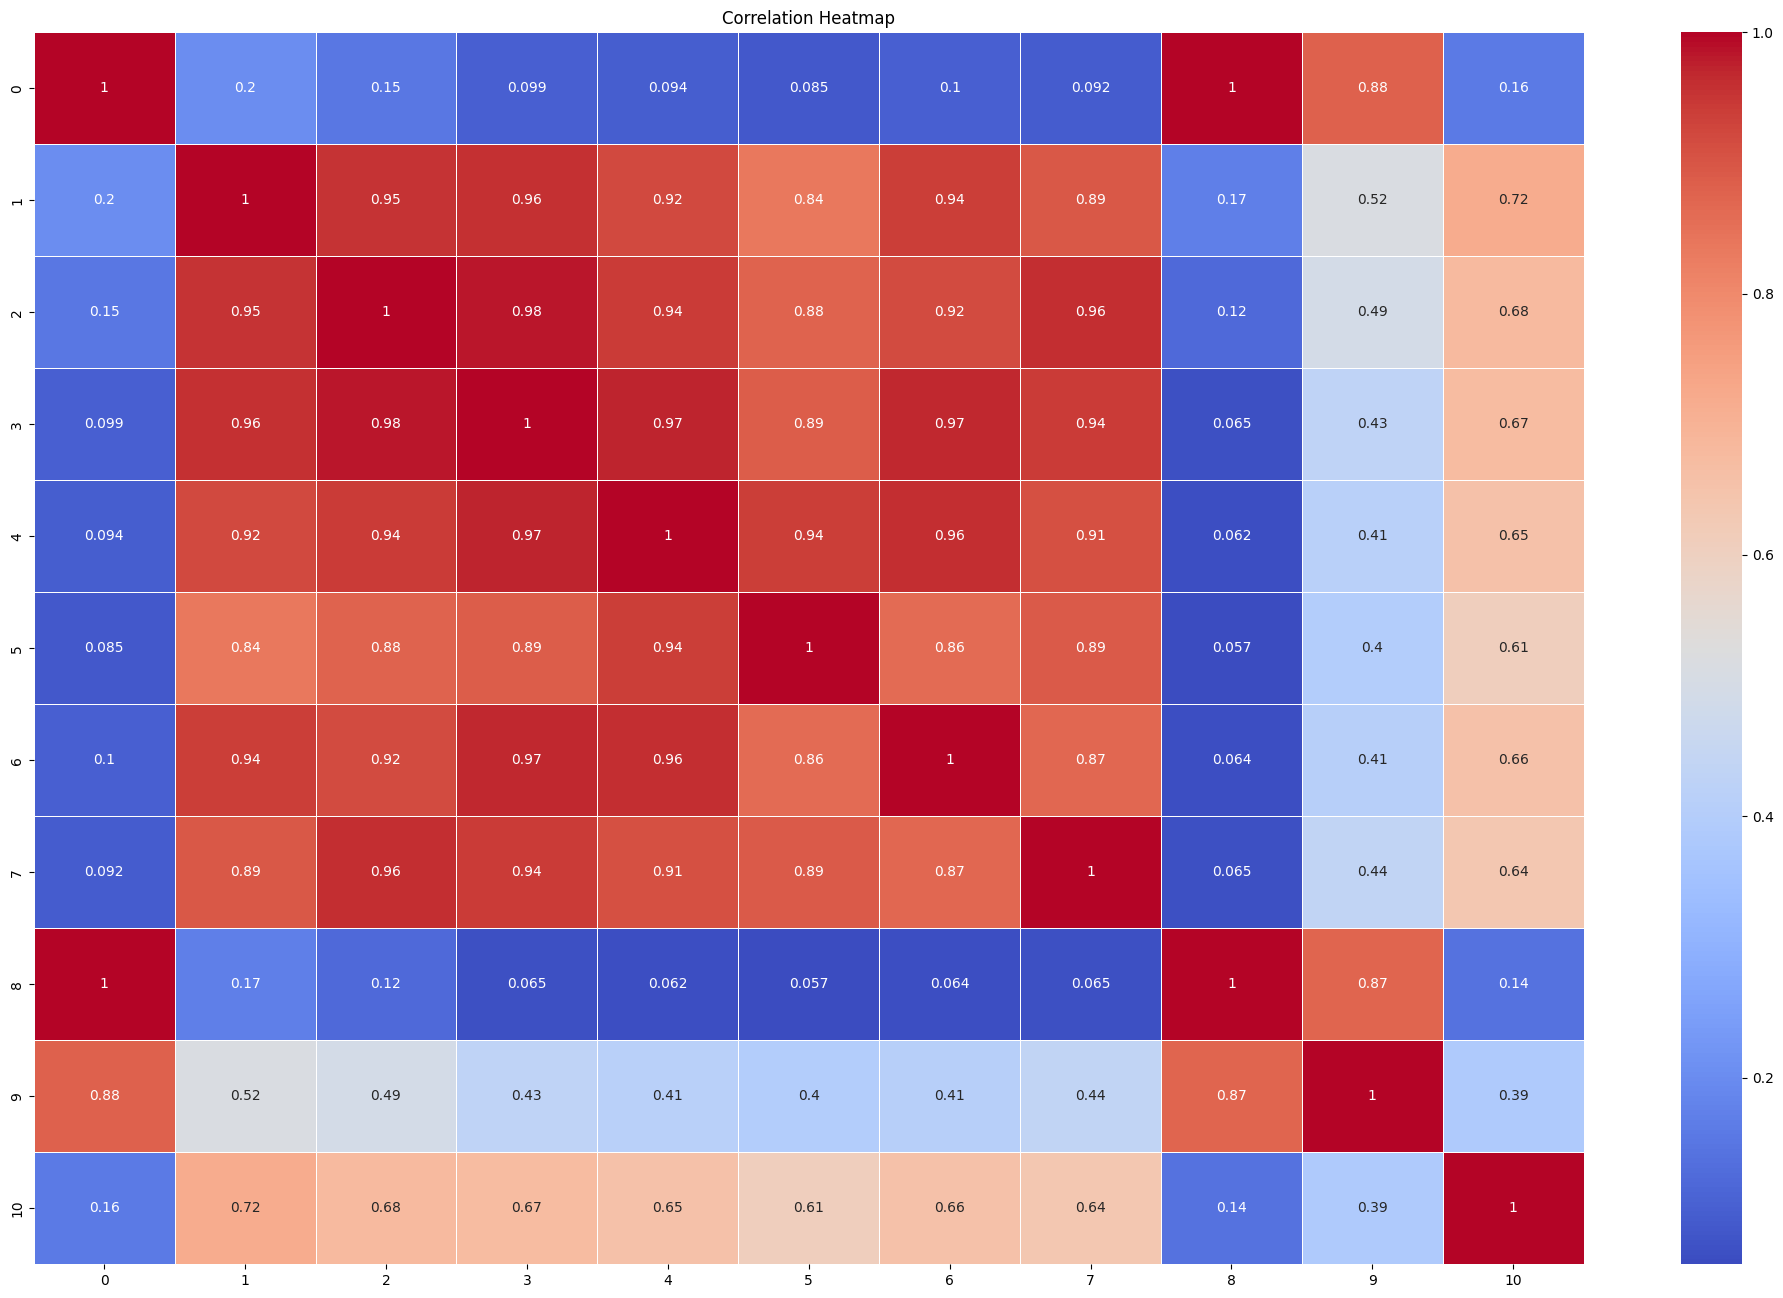

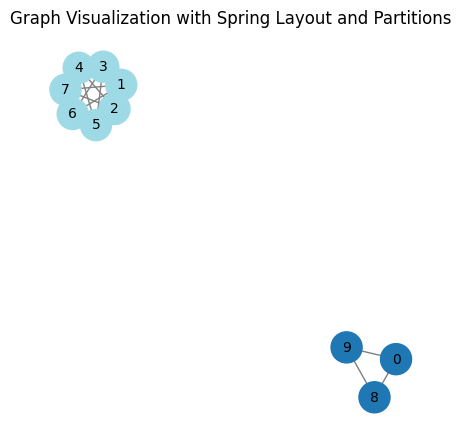

____________________________________________________________________________________________________
14 18 cols
['V138', 'V139', 'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163']


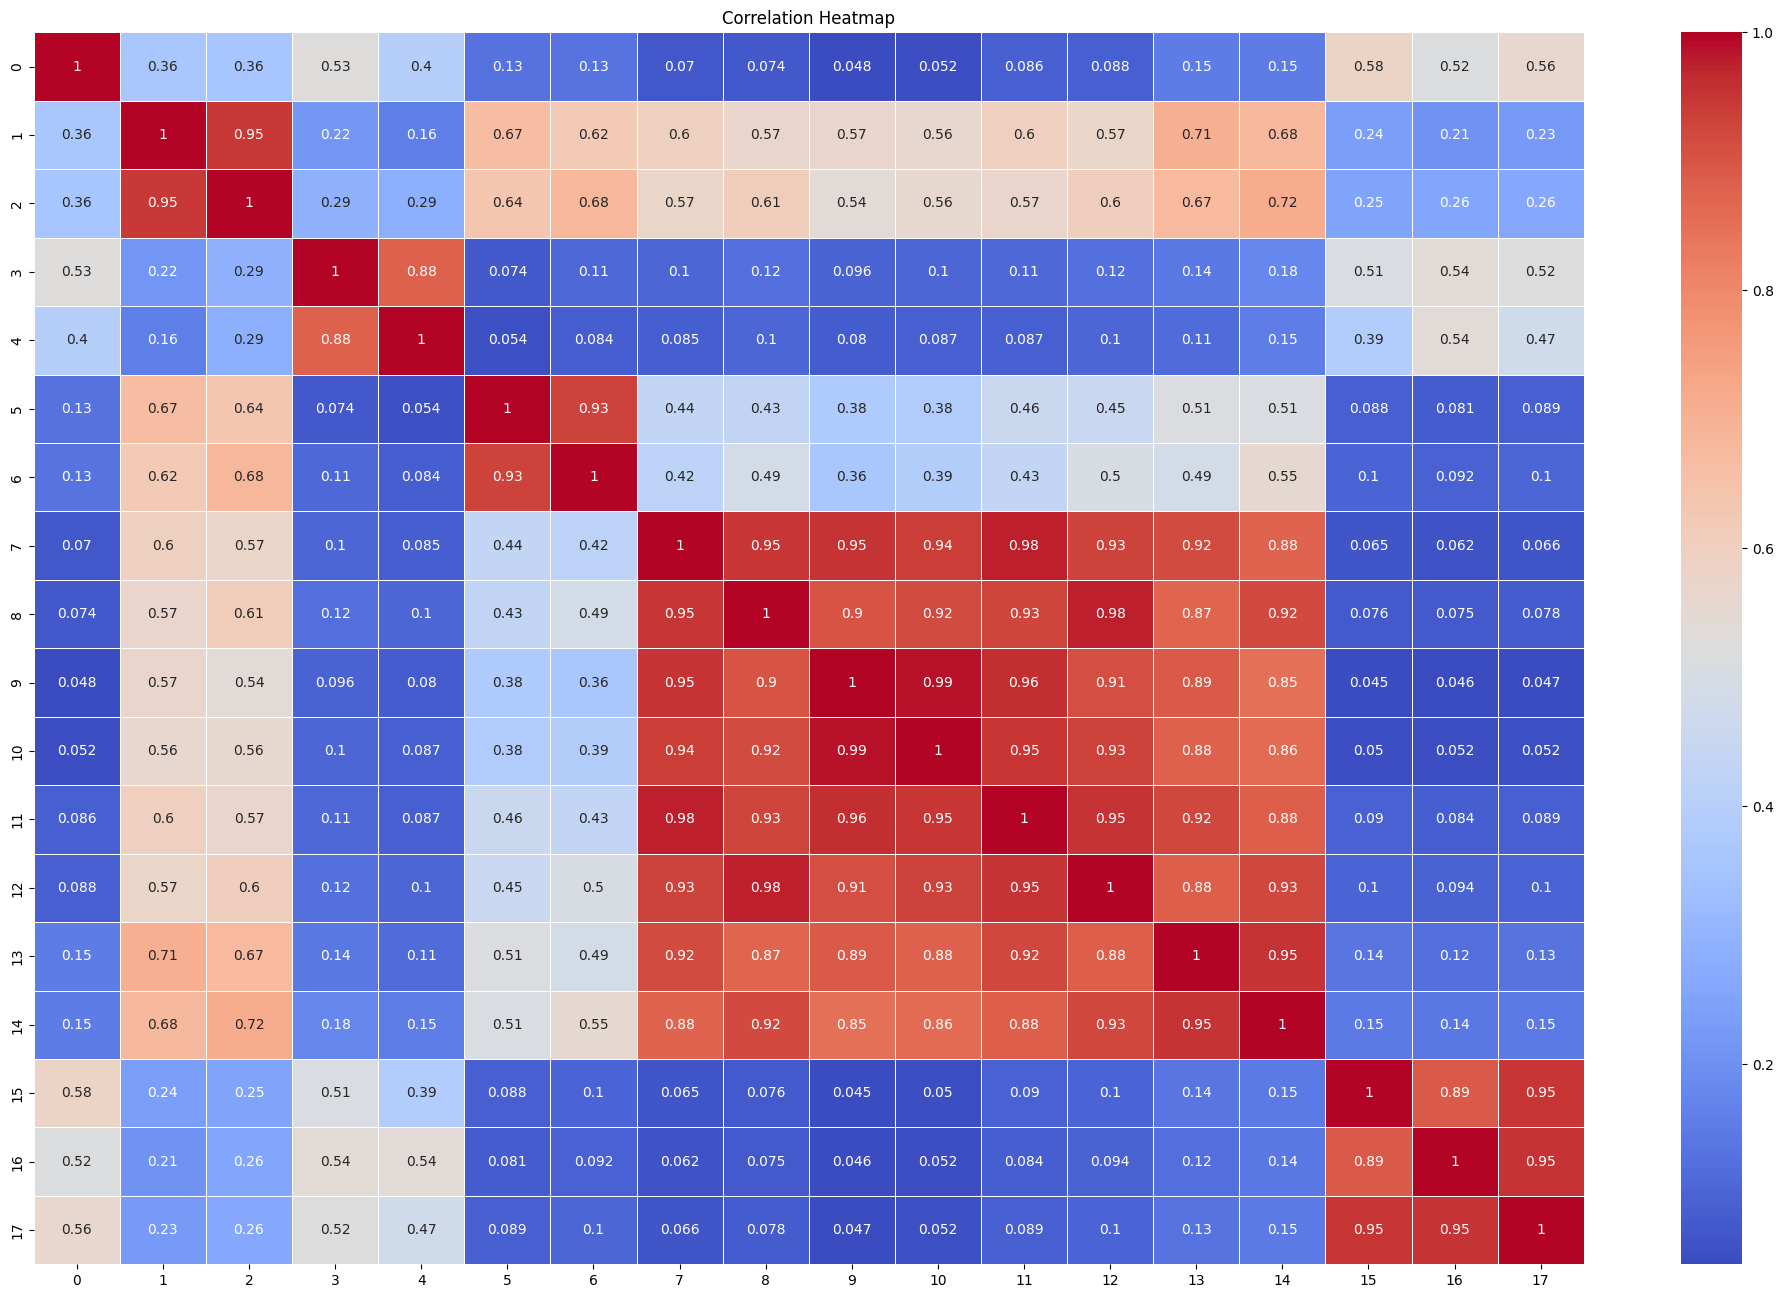

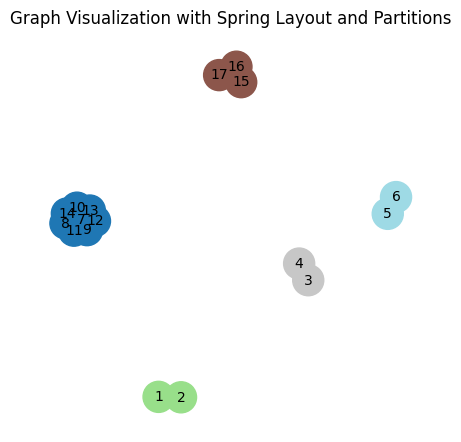

____________________________________________________________________________________________________


In [17]:
#check for correlations within each group
import itertools
import community 
import partition_networkx

grouped_cols = []
for idx, row in nan_groups.iterrows():
    print(idx, f'{len(row["cols_in_group"])} cols')
    print(row["cols_in_group"])
    cols_in_group = row["cols_in_group"]
    combinations = list(itertools.combinations(cols_in_group, 2))
    correlation = cudf.DataFrame(index=cols_in_group, columns=cols_in_group)
    for col1, col2 in combinations:
        mask = cudf_df[col1].isna()+cudf_df[col2].isna()
        correlation.loc[col1, col2] = cudf_df[col1][~mask].corr(cudf_df[col2][~mask])
        correlation.loc[col2, col1] = correlation.loc[col1, col2]
    correlation_matrix = correlation.fillna(1).astype(float).to_numpy()
    # Plot the heatmap
    plt.figure(figsize=(25, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()
    
    threshold = 0.8
    G = nx.Graph()
    for i, j in itertools.combinations(range(len(cols_in_group)), 2):
        if correlation_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=1.0)
    ec = community.ecg(G, ens_size=32)
    partitions = ec.partition
    plot_graph(G, partitions)
    partitions = {}
    for col, partition_idx in ec.partition.items():
        if partition_idx in partitions:
            partitions[partition_idx].append(col)
        else:
            partitions[partition_idx] = [col]
    grouped_cols += [[cols_in_group[idx] for idx in col_indices] 
                     for col_indices in partitions.values()]
    print('_' * 100)

In [15]:
import partition_networkx
import community
ec = community.ecg(G, ens_size=33)

partitions = ec.partition

    
partitions = {}
for col, partition_idx in ec.partition.items():
    if partition_idx in partitions:
        partitions[partition_idx].append(col)
    else:
        partitions[partition_idx] = [col]
print(len(partitions))
print(partitions)
grouped_cols += [[cols_in_group[idx] for idx in col_indices] for col_indices in partitions.values()]

5
{1: [1, 2], 2: [3, 4], 4: [5, 6], 3: [7, 8, 9, 10, 11, 12, 13, 14], 0: [15, 16, 17]}


In [18]:
print(grouped_cols)

[['V279', 'V280', 'V293', 'V294', 'V295', 'V306', 'V307', 'V308', 'V316', 'V317', 'V318'], ['V298', 'V299', 'V297'], ['V285', 'V287'], ['V290', 'V292', 'V291'], ['V302', 'V303', 'V304'], ['V309', 'V311'], ['V319', 'V321', 'V320'], ['V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V105', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134'], ['V106', 'V104'], ['V99', 'V100'], ['V108', 'V110'], ['V111', 'V113', 'V112'], ['V114', 'V116'], ['V117', 'V119'], ['V123', 'V125'], ['V135', 'V137', 'V136'], ['V288', 'V289'], ['V300', 'V301'], ['V313', 'V315', 'V314'], ['V12', 'V13'], ['V15', 'V16', 'V31', 'V33', 'V34'], ['V17', 'V18', 'V21', 'V32', 'V22'], ['V19', 'V20'], ['V23', 'V24'], ['V25', 'V26'], ['V27', 'V28'], ['V29', 'V30'], ['V53', 'V54'], ['V57', 'V58', 'V72', 'V73', 'V74'], ['V59', 'V63', 'V71', 'V60', 'V64'], ['V61', 'V62'], ['V66', 'V67'], ['V69', 'V70'], ['V75', 'V76'], ['V79', 'V94'], ['V85', 'V92', 'V93', 'V80', 'V81', 'V84'], ['V82', 'V83'], ['V86', 'V87'], ['V90', 'V91'], ['V35', 'V36'

In [19]:
file = '/kaggle/working/grouped_vs.txt'
with open(file, 'w') as f:
    for cols in grouped_cols:
        f.write(' '.join(cols) + '\n')

Code that uses cugraph.

In [ ]:
# def plot_graph(graph_df, df):
#     nx_graph = nx.Graph()
#     edge_list = graph_df.to_pandas().values
#     nx_graph.add_edges_from(edge_list)

#     # Add partitions as node attributes
#     partitions = df.set_index('vertex')['partition'].to_pandas().to_dict()
#     nx.set_node_attributes(nx_graph, partitions, "partition")

#     # Generate positions for the graph
#     pos = nx.spring_layout(nx_graph)  # Spring layout for a visually appealing structure

#     # Extract partition colors
#     partition_colors = [partitions[node] for node in nx_graph.nodes()]

#     # Plot the graph
#     plt.figure(figsize=(12, 8))
#     nx.draw(
#         nx_graph, pos,
#         with_labels=True,
#         node_color=partition_colors,
#         cmap=plt.cm.tab20,
#         node_size=500,
#         font_size=10,
#         edge_color='gray'
#     )

#     plt.title("Graph Visualization with Spring Layout and Partitions")
#     plt.show()
    

In [ ]:
# #check for correlations within each group
# import itertools
# grouped_cols = []
# for idx, row in nan_groups.iterrows():
#     print(idx, f'{len(row["cols_in_group"])} cols')
#     print(row["cols_in_group"])
#     cols_in_group = row["cols_in_group"]
#     combinations = list(itertools.combinations(cols_in_group, 2))
#     correlation = cudf.DataFrame(index=cols_in_group, columns=cols_in_group)
#     for col1, col2 in combinations:
#         mask = cudf_df[col1].isna()+cudf_df[col2].isna()
#         correlation.loc[col1, col2] = cudf_df[col1][~mask].corr(cudf_df[col2][~mask])
#         correlation.loc[col2, col1] = correlation.loc[col1, col2]
#     correlation_matrix = correlation.fillna(1).astype(float).to_cupy()
#     # Plot the heatmap
#     plt.figure(figsize=(25, 16))
#     sns.heatmap(correlation_matrix.get(), annot=True, cmap='coolwarm', linewidths=0.5)
#     plt.title("Correlation Heatmap")
#     plt.show()
    
#     threshold = 0.8
#     source, destination = cp.where(correlation_matrix > threshold)
#     graph_df = cudf.DataFrame({"source": source, "destination": destination})
#     G = cugraph.Graph(directed=False)
#     G.from_cudf_edgelist(graph_df, source='source', destination='destination', symmetrize=True)
#     df, _ = cugraph.ecg(G)
    
#     print(df.groupby('partition').agg({"vertex": "collect"}))
#     collected_partitions = df.groupby('partition').agg({"vertex": "collect"}).to_pandas()
#     grouped_cols += [[cols_in_group[idx] for idx in col_indices] for col_indices in collected_partitions['vertex'].to_list()]
#     print('_' * 150)
#     plot_graph(graph_df, df)

In [ ]:
print(len(grouped_cols))